### 销售数据分析报告及RFM模型

#### 加载数据

In [84]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

warnings.filterwarnings('ignore')
# 查看电脑的可用字体
# import matplotlib.font_manager as fm
# fonts = fm.findSystemFonts()
# for font in fonts:
#     print(font)
sns.set(context='notebook',style='darkgrid',palette='deep')
plt.rcParams['font.sans-serif'] = 'KaiTi' # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False # 显示负号

pd.set_option('display.float_format',lambda x:'%.2f'% x) # pandas 禁止使用科学及算法

#### 数据的字段介绍：
* event_time:下单时间
* order_id:订单编号
* product_id:商品编号
* category_id:产品标号
* category_code:类别编号
* brand:品牌
* price:商品价格
* user_id:用户编号
* age:年龄
* sex:性别
* local:省份

In [2]:
data = pd.read_csv(r'E:/PycharmProjects/AnalysisProjects/AnalysisDataset/电商用户消费行为分析/电子产品销售分析.csv',
                  index_col=0,dtype={'category_id':'int64','user_id':'int64'})
data.head()
# 2.268105e+18 科学计数法
# category_id；user_id科学计算发转成 int64

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2268105426648171520,electronics.tablet,samsung,162.01,1515915625441993984,24.00,女,海南
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2268105426648171520,electronics.tablet,samsung,162.01,1515915625441993984,24.00,女,海南
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2268105430162997248,electronics.audio.headphone,huawei,77.52,1515915625447879424,38.00,女,北京
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2268105430162997248,electronics.audio.headphone,huawei,77.52,1515915625447879424,38.00,女,北京
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2268105471367840000,NaN,karcher,217.57,1515915625443148032,32.00,女,广东


#### 根据下单时间创建新列：日期、月份、小时、周几

In [3]:
# 查看event_time数据
data.event_time[0]


'2020-04-24 11:50:39 UTC'

In [4]:
# 创建日期列
data['date'] = data.event_time.apply(lambda x:x.split(' ')[0])
# 转成日期格式
data['date'] = pd.to_datetime(data['date'])

# 创建月份列
data['month'] = data.date.dt.month
# 创建小时列
data['hour'] = data.event_time.apply(lambda x: x.split(' ')[1].split(":")[0])
# 创建周几列
data['weekday'] = data.date.apply(lambda x:x.strftime('%w'))


# 删除event_time列
del data['event_time']
data.head()

,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,date,month,hour,weekday
0,2294359932054536986,1515966223509089906,2268105426648171520,electronics.tablet,samsung,162.01,1515915625441993984,24.00,女,海南,2020-04-24,4,11,5
1,2294359932054536986,1515966223509089906,2268105426648171520,electronics.tablet,samsung,162.01,1515915625441993984,24.00,女,海南,2020-04-24,4,11,5
2,2294444024058086220,2273948319057183658,2268105430162997248,electronics.audio.headphone,huawei,77.52,1515915625447879424,38.00,女,北京,2020-04-24,4,14,5
3,2294444024058086220,2273948319057183658,2268105430162997248,electronics.audio.headphone,huawei,77.52,1515915625447879424,38.00,女,北京,2020-04-24,4,14,5
4,2294584263154074236,2273948316817424439,2268105471367840000,NaN,karcher,217.57,1515915625443148032,32.00,女,广东,2020-04-24,4,19,5


#### 查重、处理缺失数据

#### 处理缺失值

In [5]:
data.shape

(564169, 14)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564169 entries, 0 to 2633520
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_id       564169 non-null  int64         
 1   product_id     564169 non-null  int64         
 2   category_id    564169 non-null  int64         
 3   category_code  434799 non-null  object        
 4   brand          536945 non-null  object        
 5   price          564169 non-null  float64       
 6   user_id        564169 non-null  int64         
 7   age            564169 non-null  float64       
 8   sex            564169 non-null  object        
 9   local          564169 non-null  object        
 10  date           564169 non-null  datetime64[ns]
 11  month          564169 non-null  int64         
 12  hour           564169 non-null  object        
 13  weekday        564169 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(

In [7]:
# category_code 商品编码数据缺失严重brand也存在数据缺失的情况
# category_code 商品的缺失值通过填充的方法处理，brand缺失的数据量较少直接删除
data['category_code'] = data['category_code'].fillna('R')
data = data[data.brand.notnull()]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536945 entries, 0 to 2633520
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_id       536945 non-null  int64         
 1   product_id     536945 non-null  int64         
 2   category_id    536945 non-null  int64         
 3   category_code  536945 non-null  object        
 4   brand          536945 non-null  object        
 5   price          536945 non-null  float64       
 6   user_id        536945 non-null  int64         
 7   age            536945 non-null  float64       
 8   sex            536945 non-null  object        
 9   local          536945 non-null  object        
 10  date           536945 non-null  datetime64[ns]
 11  month          536945 non-null  int64         
 12  hour           536945 non-null  object        
 13  weekday        536945 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(

#### 重复值的处理

In [8]:
# 数据的重复值，有可能是由于同笔订单下了多个数量的订单，所以不删除重复值，进而增加一列购买数量的列和总价的列

# 查看重复值
data.duplicated().sum()

634

In [9]:
data.duplicated()

0          False
1           True
2          False
3           True
4          False
           ...  
2633516    False
2633517    False
2633518    False
2633519    False
2633520    False
Length: 536945, dtype: bool

In [10]:
# 增加新的列：购买数量
data = data.value_counts().reset_index().rename(columns={0:'buy_cnt'})
# df = data.groupby['order_id','product_id'].agg(buy_cnt=('user_id','count'))
# data = pd.merge(data,df,on=['order_id','product_id'],how='inner')
# data = data.drop_duplicates().reset_index(drop=True)
# 添加新的列：购买总金额
data['amount'] = data['price'] * data['buy_cnt']

### 查看数据是否有异常

#### 将id类型的数据的格式转化成object格式

In [11]:
data.order_id = data.order_id.astype('object')
data.product_id = data.product_id.astype('object')
data.category_id = data.category_id.astype('object')
data.user_id = data.user_id.astype('object')

#### 把hour和weekday转化成int

In [12]:
data.hour = data.hour.astype('int')
data['weekday'] = data['weekday'].astype('int')

#### 查看价格和年龄是否存在异常值

In [13]:
data.describe(percentiles=[0.01,0.25,0.75,0.99]).T
# 数据不存在异常值 price和amount的最小值是0 可能是存在商品免费赠送
# 可以分析一下 购买总金额为0的 用户是否还有购买其他的商品

,count,mean,std,min,1%,25%,50%,75%,99%,max
price,536311.00,214.54,305.98,0.00,1.13,24.51,99.51,289.33,1387.01,11574.05
age,536311.00,33.18,10.12,16.00,16.00,24.00,33.00,42.00,50.00,50.00
month,536311.00,7.72,2.56,1.00,1.00,6.00,8.00,10.00,11.00,11.00
hour,536311.00,9.52,4.21,0.00,1.00,6.00,9.00,12.00,22.00,23.00
weekday,536311.00,3.03,2.04,0.00,0.00,1.00,3.00,5.00,6.00,6.00
buy_cnt,536311.00,1.00,0.04,1.00,1.00,1.00,1.00,1.00,1.00,4.00
amount,536311.00,214.73,306.48,0.00,1.13,24.98,99.51,289.33,1387.01,11574.05


#### 检查其他字段是否有异常值

In [14]:
data.describe(include='all')
# 发现时间date存在异常值 1970-01-01 00:00:00 下一步处理时间异常值

,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,date,month,hour,weekday,buy_cnt,amount
count,536311.00,536311.00,536311.00,536311,536311,536311.00,536311.00,536311.00,536311,536311,536311,536311.00,536311.00,536311.00,536311.00,536311.00
unique,389511.00,19078.00,786.00,124,868,NaN,92769.00,NaN,2,11,323,NaN,NaN,NaN,NaN,NaN
top,2388440981134689792.00,1515966223517847040.00,2268105428166508800.00,R,samsung,NaN,1515915625512422912.00,NaN,男,广东,2020-10-22 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,47.00,2755.00,101081.00,116093,96123,NaN,1026.00,NaN,270454,117097,8310,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-21 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,214.54,NaN,33.18,NaN,NaN,NaN,7.72,9.52,3.03,1.00,214.73
std,NaN,NaN,NaN,NaN,NaN,305.98,NaN,10.12,NaN,NaN,NaN,2.56,4.21,2.04,0.04,306.48
min,NaN,NaN,NaN,NaN,NaN,0.00,NaN,16.00,NaN,NaN,NaN,1.00,0.00,0.00,1.00,0.00
25%,NaN,NaN,NaN,NaN,NaN,24.51,NaN,24.00,NaN,NaN,NaN,6.00,6.00,1.00,1.00,24.98


#### 处理时间date中的异常值

In [15]:
# 异常值1970-01-01 00:00:00 删除
data = data[data.date > '1970-01-01']

In [16]:
data.date.min()

Timestamp('2020-01-05 00:00:00')

### 对清洗完的数据进行数据分析

In [17]:
data.head()

,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,date,month,hour,weekday,buy_cnt,amount
0,2318945879811162983,2309018204833317816,2268105479144079872,R,compliment,0.56,1515915625465863936,28.00,女,浙江,2020-05-28,5,9,4,4,2.24
1,2295740594749702229,1515966223509104892,2268105428166508800,electronics.smartphone,apple,1387.01,1515915625448766464,21.00,男,北京,2020-04-26,4,9,0,4,5548.04
2,2388440981134674698,1515966223509106757,2360741867017995776,appliances.environment.air_conditioner,samsung,366.41,1515915625514599680,50.00,男,广东,2020-11-16,11,4,1,4,1465.64
3,2375043331555066740,2273948308370096764,2268105409048871168,computers.network.router,altel,57.85,1515915625504379136,19.00,女,上海,2020-08-13,8,19,4,4,231.40
4,2334999887038383089,1515966223509090031,2268105402673529600,R,vitek,18.50,1515915625447765248,18.00,男,广东,2020-06-19,6,13,5,3,55.50


In [18]:
data.shape

(535065, 16)

In [19]:
data.reset_index(drop=True,inplace=True)

In [20]:
# 保存清洗后的数据
data.to_csv('data_clean.csv',index=False)

#### 总的指标

##### 总GMV(总销售额):

In [21]:
round(data['amount'].sum(),2)

114986635.88

##### 每个月的GMV
GMV在8月份之前基本处于一个上升状态，其中7到8月的上升幅度最大，并在8月达到峰值，然后开始下降

In [22]:
GMV_month = data.groupby('month').agg(GMV=('amount','sum'))
GMV_month

,GMV
month,
1,1729464.93
2,2216672.31
3,2841015.58
4,1674450.68
5,7657332.51
6,7489312.32
7,16048807.99
8,27380899.66
9,16797132.61


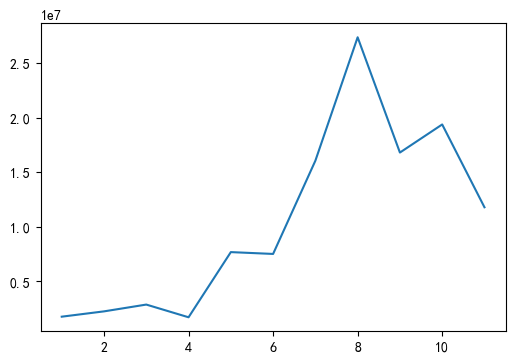

In [23]:
# 绘制GMV_month的折线图
plt.figure(figsize=(6,4))
plt.plot(GMV_month.index,GMV_month.values)

##### 客单价：

In [24]:
# 按照客户数量
round(data['amount'].sum()/data['user_id'].nunique(),0)

1240.0

In [25]:
# 按照订单数量来算
round(data['amount'].sum()/data['order_id'].nunique(),0)

296.0

#### 用户行为分析

##### 用户总量

In [26]:
data = pd.read_csv('./data_clean.csv')
data.head()

,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,date,month,hour,weekday,buy_cnt,amount
0,2318945879811162983,2309018204833317816,2268105479144079872,R,compliment,0.56,1515915625465863936,28.00,女,浙江,2020-05-28,5,9,4,4,2.24
1,2295740594749702229,1515966223509104892,2268105428166508800,electronics.smartphone,apple,1387.01,1515915625448766464,21.00,男,北京,2020-04-26,4,9,0,4,5548.04
2,2388440981134674698,1515966223509106757,2360741867017995776,appliances.environment.air_conditioner,samsung,366.41,1515915625514599680,50.00,男,广东,2020-11-16,11,4,1,4,1465.64
3,2375043331555066740,2273948308370096764,2268105409048871168,computers.network.router,altel,57.85,1515915625504379136,19.00,女,上海,2020-08-13,8,19,4,4,231.40
4,2334999887038383089,1515966223509090031,2268105402673529600,R,vitek,18.50,1515915625447765248,18.00,男,广东,2020-06-19,6,13,5,3,55.50


In [27]:
# 将date转化成日期格式
data['date'] = pd.to_datetime(data['date'])

In [28]:
# 查看用户数量
data.user_id.nunique()

92755

##### 查看不同地区用户数量

In [29]:
local = data.groupby('local')['user_id'].nunique().reset_index()
local = local.rename(columns={'user_id':'用户数量'})
local = local.sort_values('用户数量').reset_index(drop=True)
local

,local,用户数量
0,湖南,5330
1,天津,5337
2,重庆,5342
3,湖北,5355
4,浙江,5370
5,四川,5445
6,海南,5449
7,江苏,5561
8,北京,15928
9,上海,16031


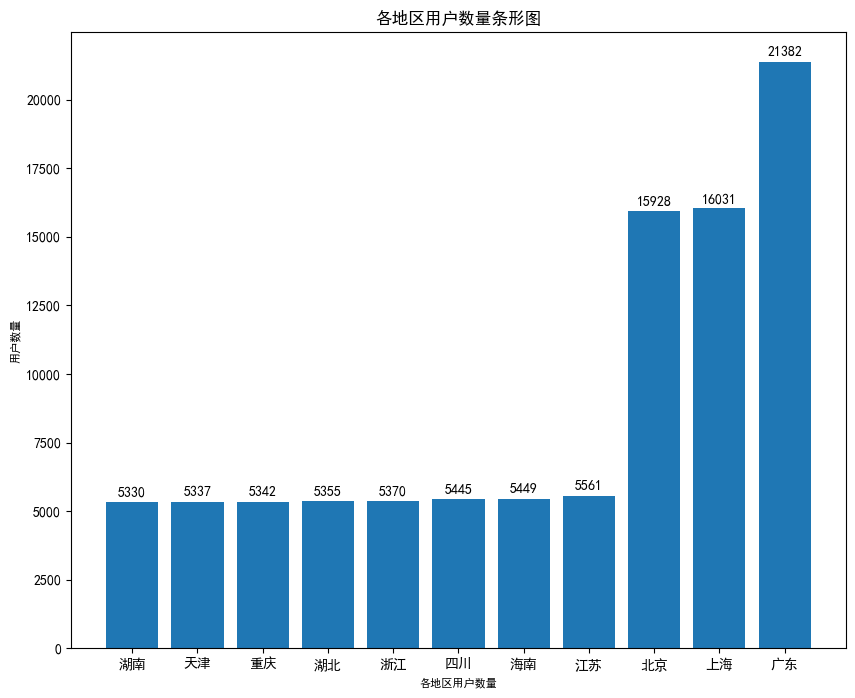

In [30]:
# 绘制该地区用户数量条形图
plt.figure(figsize=(10,8))
plt.bar(local.local,local['用户数量'])
plt.ylabel('用户数量',fontsize=8)
plt.xlabel('各地区用户数量',fontsize=8)
plt.title('各地区用户数量条形图')
for x,y in enumerate(local['用户数量']):
    plt.text(x,y+200,y,ha='center')
plt.show()

广东地区的用户数量最多，然后是上海和北京，其他八个城市用户数比较平均，基本处在5400左右

###### 根据2020年的全国人口普查数据，分析各省的用户占比

In [31]:
population = pd.read_excel(r'E:/PycharmProjects/AnalysisProjects/AnalysisDataset/电商用户消费行为分析/2020年各省人口数量.xlsx')
population = population.iloc[:,:2]
population.head()

,地区,人口数
0,全国,1411778724
1,广东,126012510
2,山东,101527453
3,河南,99365519
4,江苏,84748016


In [32]:
local.head()

,local,用户数量
0,湖南,5330
1,天津,5337
2,重庆,5342
3,湖北,5355
4,浙江,5370


In [33]:
local = pd.merge(local,population,how='inner',left_on='local',right_on='地区')
# local.head()

In [34]:
local['占比'] = local['用户数量']/local['人口数']
local = local.sort_values('占比',ascending=False).reset_index(drop=True)
local

,local,用户数量,地区,人口数,占比
0,北京,15928,北京,21893095,0.00
1,上海,16031,上海,24870895,0.00
2,海南,5449,海南,10081232,0.00
3,天津,5337,天津,13866009,0.00
4,广东,21382,广东,126012510,0.00
5,重庆,5342,重庆,32054159,0.00
6,湖北,5355,湖北,57752557,0.00
7,浙江,5370,浙江,64567588,0.00
8,湖南,5330,湖南,66444864,0.00
9,江苏,5561,江苏,84748016,0.00


从表中可以看到，用户数量占比的前三名分别是:上海、北京、天津,第四的天津，广东第五，广东的占比仅是第一名北京的五分之一，加之广东的人口众多，可以在广东地区进行拉新活动的锌价比是最高的

##### 用户性别分布

In [35]:
sex = data.groupby('sex')['user_id'].nunique().reset_index()
sex.rename(columns={'user_id':'用户数量'},inplace=True)
sex

,sex,用户数量
0,女,47235
1,男,47628


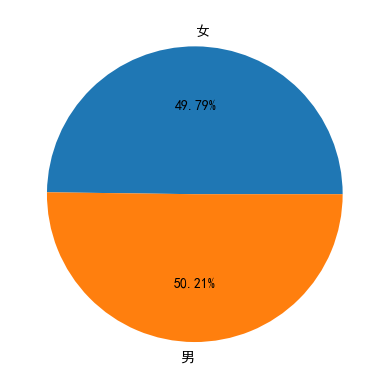

In [36]:
_ = plt.pie(sex['用户数量'],labels=sex['sex'],autopct='%1.2f%%')

##### 年龄分布

In [37]:
data.age.min()

16.0

In [38]:
data.age.max()

50.0

In [39]:
# 将各年龄段的用户进行分箱
bins = [15,20,25,30,35,40,45,50]
labels = ['(15-20]岁','(20-25]岁','(25-30]岁','(30-35]岁','(35-40]岁','(40-45]岁','(45-50]岁']
data_ = data.copy()
data_['age_bin'] = pd.cut(x=data.age,bins=bins,right=True,labels=labels)
data_

,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,date,month,hour,weekday,buy_cnt,amount,age_bin
0,2318945879811162983,2309018204833317816,2268105479144079872,R,compliment,0.56,1515915625465863936,28.00,女,浙江,2020-05-28,5,9,4,4,2.24,(25-30]岁
1,2295740594749702229,1515966223509104892,2268105428166508800,electronics.smartphone,apple,1387.01,1515915625448766464,21.00,男,北京,2020-04-26,4,9,0,4,5548.04,(20-25]岁
2,2388440981134674698,1515966223509106757,2360741867017995776,appliances.environment.air_conditioner,samsung,366.41,1515915625514599680,50.00,男,广东,2020-11-16,11,4,1,4,1465.64,(45-50]岁
3,2375043331555066740,2273948308370096764,2268105409048871168,computers.network.router,altel,57.85,1515915625504379136,19.00,女,上海,2020-08-13,8,19,4,4,231.40,(15-20]岁
4,2334999887038383089,1515966223509090031,2268105402673529600,R,vitek,18.50,1515915625447765248,18.00,男,广东,2020-06-19,6,13,5,3,55.50,(15-20]岁
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535060,2358865589969092889,1515966223509130354,2268105389587300864,appliances.kitchen.dishwasher,gorenje,578.68,1515915625455555072,48.00,男,重庆,2020-07-22,7,11,3,1,578.68,(45-50]岁
535061,2358865589969092889,1515966223509122768,2268105388555502080,appliances.kitchen.oven,bosch,300.90,1515915625455555072,48.00,男,重庆,2020-07-22,7,11,3,1,300.90,(45-50]岁
535062,2358865589969092889,1515966223509104818,2268105389956400128,appliances.kitchen.washer,lg,289.33,1515915625455555072,48.00,男,重庆,2020-07-22,7,11,3,1,289.33,(45-50]岁
535063,2358865589969092889,1515966223509088622,2374498914000592384,electronics.video.tv,lg,370.35,1515915625455555072,48.00,男,重庆,2020-07-22,7,11,3,1,370.35,(45-50]岁


In [40]:
age = data_.groupby('age_bin')['user_id'].nunique().reset_index()
age.rename(columns={'user_id':'用户数量'},inplace=True)
age

,age_bin,用户数量
0,(15-20]岁,13726
1,(20-25]岁,13867
2,(25-30]岁,13831
3,(30-35]岁,13802
4,(35-40]岁,13775
5,(40-45]岁,13969
6,(45-50]岁,13535


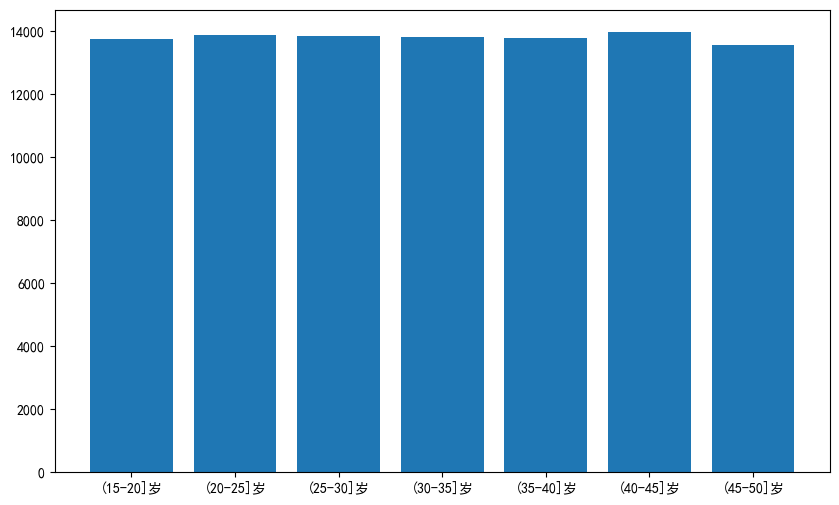

In [41]:
# 绘制年龄分布直方图
plt.figure(figsize=(10,6))
plt.bar(age['age_bin'],age['用户数量'])
plt.show()

用户年龄均匀分布在16-50之间

In [42]:
# 查看各个年龄的用户数量
data_.groupby('age')['user_id'].nunique().reset_index()

,age,user_id
0,16.00,2797
1,17.00,2725
2,18.00,2759
3,19.00,2703
4,20.00,2838
5,21.00,2786
6,22.00,2792
7,23.00,2820
8,24.00,2764
9,25.00,2768


##### 各年龄段的消费金额及下单数量

In [43]:
age_bin_data = data_.groupby('age_bin').agg(消费金额=('amount','sum'),下单次数=('order_id','nunique'))
age_bin_data

,消费金额,下单次数
age_bin,,
(15-20]岁,16007287.18,54302
(20-25]岁,16500743.70,55546
(25-30]岁,16513446.00,54723
(30-35]岁,17004578.70,58275
(35-40]岁,14995577.44,49744
(40-45]岁,17078724.54,59067
(45-50]岁,16886278.32,57085


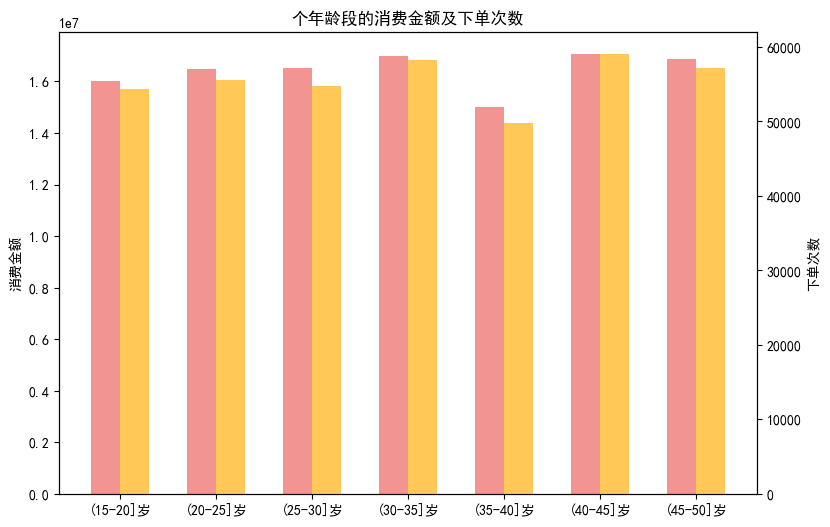

In [44]:
fig,ax1 = plt.subplots(figsize=(9,6))
xticks = np.arange(len(age_bin_data.index))

ax1.bar(xticks,age_bin_data['消费金额'],width=0.3,color='#F29492')
ax1.set_ylabel('消费金额')
ax2 = ax1.twinx()

ax2.bar(xticks + 0.3,age_bin_data['下单次数'],width=0.3,color='#FFC857')
ax2.set_ylabel('下单次数')
plt.title('个年龄段的消费金额及下单次数')

ax1.set_xticks(xticks + 0.15)
ax1.set_xticklabels(age_bin_data.index)
plt.show()

30-40岁的用户，贡献的消费金额与下单的数量都是最低的，其他年龄段的比较平均

##### 男性女性的消费金额及下单数量

In [45]:
sex_data = data_.groupby('sex').agg(消费金额=('amount','sum'),下单次数=('order_id','nunique'))
sex_data

,消费金额,下单次数
sex,,
女,57108456.57,192394
男,57878179.31,196348


男女消费者的消费次数和金额都比较平均

##### 分析购买了0元产品的用户

In [46]:
cond = data['price']==0

In [47]:
# 提取该批用户
user_zero = data[cond]['user_id'].reset_index(drop=True)
user_zero

0     1515915625505436160
1     1515915625498229248
2     1515915625512202240
3     1515915625498273536
4     1515915625498244096
5     1515915625514162432
6     1515915625467158528
7     1515915625514596864
8     1515915625512817664
9     1515915625512118784
10    1515915625512763136
11    1515915625512762368
12    1515915625512763904
13    1515915625512377088
14    1515915625513058048
15    1515915625498201088
16    1515915625446041088
17    1515915625486717696
18    1515915625512678912
19    1515915625479406336
20    1515915625446041088
21    1515915625468531712
22    1515915625446572032
23    1515915625484648960
24    1515915625484652288
25    1515915625484627200
26    1515915625484641280
27    1515915625484619520
28    1515915625484629760
29    1515915625449238016
Name: user_id, dtype: int64

##### 用二八定律-找出累计贡献销售额80%的那批用户

In [48]:
user_28 = data.groupby('user_id').agg(消费金额=('amount','sum')).sort_values('消费金额',ascending=False).reset_index()
user_28['累计销售额'] = user_28['消费金额'].cumsum()
user_28

,user_id,消费金额,累计销售额
0,1515915625512422912,160604.07,160604.07
1,1515915625513695488,158277.37,318881.44
2,1515915625512377088,149967.06,468848.50
3,1515915625513577472,135672.84,604521.34
4,1515915625514597888,133945.88,738467.22
...,...,...,...
92750,1515915625511079936,0.02,114986635.82
92751,1515915625450548736,0.02,114986635.84
92752,1515915625506653440,0.02,114986635.86
92753,1515915625451367168,0.02,114986635.88


In [49]:
# 前27%的用户贡献了80%的销售收入
p = user_28['消费金额'].cumsum()/user_28['消费金额'].sum() # 创建累计的占比Series
key = p[p>0.8].index[0]
key

25408

In [50]:
# 查看提供销售额的80%的用户占全体用户的比列
key / user_28.shape[0]

0.2739259339119185

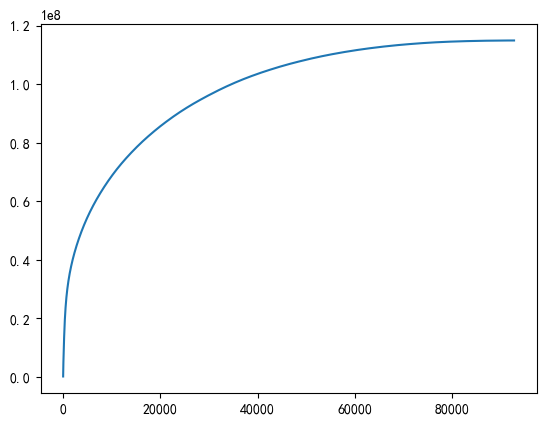

In [51]:
plt.plot(user_28.index,user_28['累计销售额'])
plt.show()

前27%的用户贡献了总销售额的80%,这批用户要做好跟进，留住这批客户

##### 客户消费金额的分位数

In [52]:
data.groupby('user_id').agg(消费金额=('amount','sum')).describe(percentiles=(0.01,0.25,0.5,0.75,0.99)).T



,count,mean,std,min,1%,25%,50%,75%,99%,max
消费金额,92755.00,1239.68,4129.72,0.00,6.00,148.11,456.89,1141.17,12744.87,160604.07


用户的平均消费金额大于75%分位数，即存在高消费的客户

##### 客户消费周期

In [53]:
purchase_day = data[data['amount']>0].sort_values('date').groupby('user_id').apply(lambda x:x['date'] - x['date'].shift()).dt.days
purchase_day

user_id                    
1515915625439951872  272401     NaN
1515915625440038400  772        NaN
                     249406   36.00
1515915625440051712  263909     NaN
                     263947    0.00
                               ... 
1515915625514888704  179016     NaN
                     178995    0.00
                     178959    0.00
1515915625514891008  179001     NaN
1515915625514891264  178994     NaN
Name: date, Length: 535035, dtype: float64

In [54]:
purchase_day[purchase_day>0].describe(percentiles=[0.01,0.1,0.25,0.75,0.9])

count   139989.00
mean        21.06
std         31.44
min          1.00
1%           1.00
10%          1.00
25%          2.00
50%          7.00
75%         26.00
90%         63.00
max        299.00
Name: date, dtype: float64

##### 每月新客户，不活跃客户，回流客户，活跃客户的情况

In [55]:
# 数据透视
pivoted_amount = data[data['amount']>0].pivot_table(index='user_id',
                                                   columns='month',
                                                   values='buy_cnt',
                                                   aggfunc='sum').fillna(0)
columns_month = pivoted_amount.columns.astype('str') # 将列名转化成字符串
pivoted_amount.columns = columns_month
pivoted_purchase = pivoted_amount.applymap(lambda x:1 if x>0 else 0)

In [56]:
def active_status(data):
    status = []
    for i in range(11): # 一共有十一个月的数据
        # 若本月没有消费
        if data[i] == 0:
            if len(status) > 0: # 如果不是第一个月
                if status[i-1]=='未注册': #如果上个月已经是未注册，那么本月也是未注册
                    status.append('未注册')
                else: # 如果上月已注册 则本月为不活跃
                    status.append('不活跃')
            else: #如果是第一个月
                status.append('未注册') # 则未注册
        # 若本月消费
        else:
            if len(status)==0: # 如果是第一个月 则为新注册用户
                status.append('新客户')
            else: # 如果不是第一个月
                if status[i-1]=='不活跃': # 如果上月为不活跃 那么本月为回流
                    status.append('回流')
                elif status[i-1]=='未注册': # 如果上月为未注册 那么本月为新注册
                    status.append('新客户')
                else: # 如果上月为活跃 本月也为活跃
                    status.append('活跃')
    return pd.Series(status,index=columns_month)

In [57]:
pivoted_purchase_status = pivoted_purchase.apply(lambda x:active_status(x),axis=1)
pivoted_purchase_status.head()

month,1,2,3,4,5,6,7,8,9,10,11
user_id,,,,,,,,,,,
1515915625439951872,未注册,未注册,未注册,未注册,未注册,未注册,新客户,不活跃,不活跃,不活跃,不活跃
1515915625440038400,未注册,未注册,未注册,未注册,未注册,未注册,未注册,未注册,新客户,活跃,不活跃
1515915625440051712,未注册,未注册,未注册,未注册,未注册,未注册,未注册,未注册,未注册,新客户,活跃
1515915625440099840,未注册,未注册,未注册,未注册,新客户,活跃,活跃,不活跃,回流,活跃,活跃
1515915625440121600,未注册,未注册,未注册,未注册,新客户,不活跃,回流,不活跃,不活跃,不活跃,不活跃


In [58]:
# unreg 未注册
# unactive 不活跃
# new 新注册
# active 活跃
# return 回流--不活跃后第一次活跃即为回流

In [59]:
purchase_cnt  = pivoted_purchase_status.apply(lambda x:x.value_counts())
# 去除未注册的数据行
purchase_cnt = purchase_cnt[purchase_cnt.index !='未注册']
purchase_cnt = purchase_cnt.fillna(0)
# 排序 可以不排
purchase_cnt = purchase_cnt.loc[['新客户','回流','活跃','不活跃'],:]
purchase_cnt

month,1,2,3,4,5,6,7,8,9,10,11
新客户,1813.00,1613.00,1491,4177,13914,8950,22036,22052,8163,5607,2938.00
回流,0.00,0.00,261,432,1377,1251,3462,4244,4199,3740,2444.00
活跃,0.00,623.00,819,800,1865,3639,4309,8765,7182,4941,3116.00
不活跃,0.00,1190.00,2346,3685,5852,18118,24187,40985,64665,75528,84256.00


<Axes: xlabel='month'>

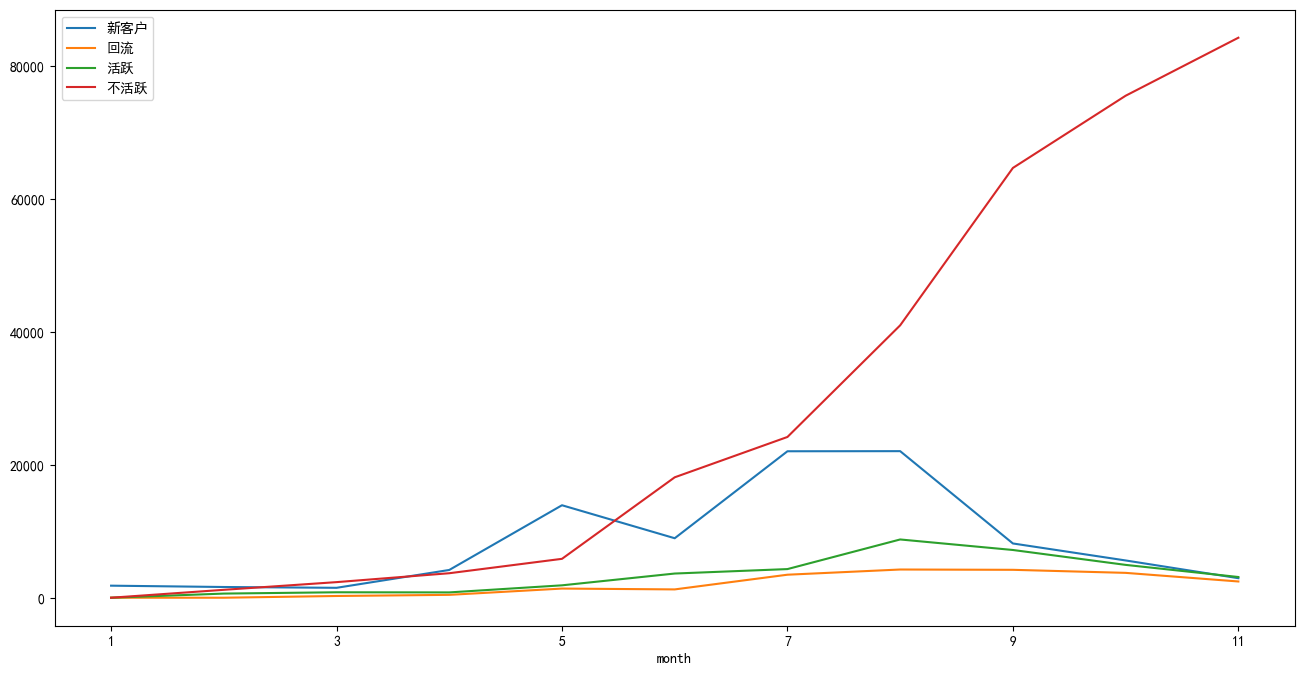

In [60]:
purchase_cnt.T.plot(figsize=(16,8))

#### 产品分析

In [61]:
data.head()

,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,date,month,hour,weekday,buy_cnt,amount
0,2318945879811162983,2309018204833317816,2268105479144079872,R,compliment,0.56,1515915625465863936,28.00,女,浙江,2020-05-28,5,9,4,4,2.24
1,2295740594749702229,1515966223509104892,2268105428166508800,electronics.smartphone,apple,1387.01,1515915625448766464,21.00,男,北京,2020-04-26,4,9,0,4,5548.04
2,2388440981134674698,1515966223509106757,2360741867017995776,appliances.environment.air_conditioner,samsung,366.41,1515915625514599680,50.00,男,广东,2020-11-16,11,4,1,4,1465.64
3,2375043331555066740,2273948308370096764,2268105409048871168,computers.network.router,altel,57.85,1515915625504379136,19.00,女,上海,2020-08-13,8,19,4,4,231.40
4,2334999887038383089,1515966223509090031,2268105402673529600,R,vitek,18.50,1515915625447765248,18.00,男,广东,2020-06-19,6,13,5,3,55.50


##### 销量前十产品

In [62]:
cnt = data.groupby('product_id').agg(销售总量=('buy_cnt','sum')).reset_index().sort_values('销售总量',ascending=False).reset_index(drop=True)
cnt.head(10)

,product_id,销售总量
0,1515966223517846928,2759
1,1515966223509106786,2597
2,1515966223509088532,2550
3,1515966223509088613,2549
4,1515966223509088567,2497
5,1515966223510174551,2370
6,1515966223509088521,2156
7,1515966223509104145,2037
8,1515966223509088639,1904
9,1515966223509117074,1797


对于热销产品，应该时刻关注他们的库存量，避免发生缺货情况

##### 销量小于10的产品

In [63]:
cnt.describe(percentiles=(0.01,0.1,0.25,0.75,0.9,0.99))

,product_id,销售总量
count,19053.00,19053.00
mean,1799977560495258624.00,28.12
std,381362937154169920.00,93.48
min,1515966223509088512.00,1.00
1%,1515966223509089280.00,1.00
10%,1515966223509118464.00,1.00
25%,1515966223509298688.00,2.00
50%,1515966223510604544.00,5.00
75%,2273948287155306752.00,19.00
90%,2309018263300237312.00,64.00


In [64]:
cnt[cnt['销售总量'] < 10]

,product_id,销售总量
6984,1515966223510210803,9
6985,1515966223510177837,9
6986,1515966223510338401,9
6987,1515966223509117524,9
6988,1515966223509106104,9
...,...,...
19048,2273948297037087392,1
19049,1515966223510071726,1
19050,2273948297011921539,1
19051,2273948297011921538,1


对于销量小于10的产品，可以考虑促销活动对其进行清仓处理

##### 销售额前十的产品

In [65]:
amount_top_10 = data.groupby('product_id').agg(销售总额=('amount','sum')).reset_index().sort_values('销售总额',ascending=False).reset_index(drop=True)
amount_top_10[:11]

,product_id,销售总额
0,1515966223509088567,2138006.31
1,1515966223509088671,1540314.88
2,1515966223509089284,1062128.50
3,1515966223509088628,1007196.96
4,1515966223509088509,921041.65
5,1515966223509089438,850236.39
6,1515966223509088532,767295.00
7,1515966223509104892,760081.48
8,1515966223509105893,739893.40
9,1515966223509088639,661068.80


In [66]:
amount_top_10.describe(percentiles=(0.01,0.25,0.5,0.75,0.9,0.99))

,product_id,销售总额
count,19053.00,19053.00
mean,1799977560495258880.00,6035.09
std,381362937154172544.00,35954.79
min,1515966223509088512.00,0.00
1%,1515966223509089280.00,0.46
25%,1515966223509298688.00,52.80
50%,1515966223510604544.00,323.10
75%,2273948287155306752.00,1909.49
90%,2309018263300237312.00,9436.11
99%,2388434452476071936.00,100748.55


##### 销量前十的产品类别category_code

In [67]:
cnt_category = data[data.category_code != 'R'].groupby('category_code').agg(销量=('buy_cnt','sum')).reset_index().sort_values('销量',ascending=False).reset_index(drop=True)
cnt_category.head(10)

,category_code,销量
0,electronics.smartphone,102169
1,computers.notebook,25860
2,appliances.kitchen.refrigerators,20020
3,electronics.audio.headphone,19739
4,electronics.video.tv,17623
5,appliances.environment.vacuum,15906
6,appliances.kitchen.washer,14163
7,appliances.kitchen.kettle,11869
8,computers.peripherals.mouse,10146
9,furniture.kitchen.table,9659


销量第一的是smartphone手机，第二是notebook手提电脑的4倍

##### 对于手机，销量前五的品牌-brand

In [68]:
brand_top_5 = data[data.category_code == 'electronics.smartphone'].groupby('brand').agg(销量=('buy_cnt','sum')).reset_index().sort_values('销量',ascending=False).reset_index(drop=True)
brand_top_5

,brand,销量
0,samsung,51376
1,apple,23365
2,xiaomi,8328
3,huawei,7738
4,oppo,6876
5,honor,1993
6,vivo,825
7,sony,517
8,awax,490
9,eset,369


In [69]:
brand_top_5[:5]['销量'].sum()

97683

手机销量前五的分别是samsung、apple、xiaomi、huawei、oppo，其中三星占了一半以上的份额，苹果占四分之一

In [70]:
import seaborn as sns
sns.set(context='notebook',style='darkgrid',palette='deep')

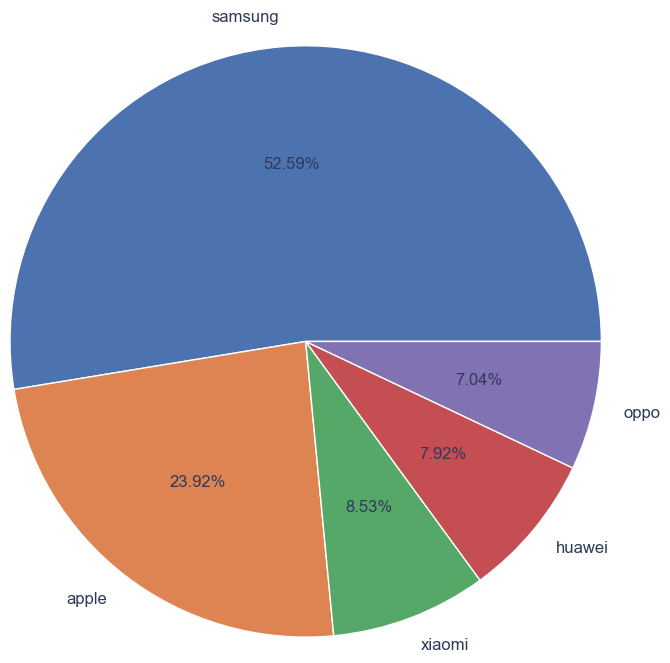

In [71]:
# 绘制手机销量前五的占比图
plt.pie(data=brand_top_5.head(5)
       ,x='销量'
       ,labels='brand'
       ,autopct='%.2f%%'
       ,textprops={'fontsize':12,'color':'#2F3A59'}
       ,radius=2
       )
plt.show()

##### 分析销量前五的手机品牌的人群特征

###### samsung品牌
* 年龄分布比较平均
* 男女比列也是平均
* 广东、上海、北京占据了50%的销售量

年龄分布

In [72]:
user_samsung = data_.loc[(data_['brand']=='samsung')&(data_['category_code']=='electronics.smartphone')]
user_samsung.head()

,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,date,month,hour,weekday,buy_cnt,amount,age_bin
10,2316018244177101460,1515966223509104666,2268105428166508800,electronics.smartphone,samsung,196.27,1515915625513724928,31.00,女,上海,2020-05-24,5,9,0,3,588.81,(30-35]岁
12,2316016961902871022,1515966223509104666,2268105428166508800,electronics.smartphone,samsung,196.27,1515915625513724928,31.00,女,上海,2020-05-24,5,8,0,3,588.81,(30-35]岁
17,2370951239572652555,1515966223509089514,2268105428166508800,electronics.smartphone,samsung,254.61,1515915625465380096,50.00,女,湖北,2020-08-08,8,4,6,3,763.83,(45-50]岁
21,2388245004955943032,1515966223509089425,2268105428166508800,electronics.smartphone,samsung,115.72,1515915625510724352,37.00,女,广东,2020-09-01,9,0,2,2,231.44,(35-40]岁
23,2387762635828363281,1515966223538328768,2268105428166508800,electronics.smartphone,samsung,81.00,1515915625508765184,24.00,女,广东,2020-08-31,8,8,1,2,162.00,(20-25]岁


In [73]:
# 查看不同年龄段的销量情况
user_samsung.groupby('age_bin').agg(销量=('buy_cnt','sum'))

,销量
age_bin,
(15-20]岁,7273
(20-25]岁,7125
(25-30]岁,7320
(30-35]岁,7593
(35-40]岁,6774
(40-45]岁,7651
(45-50]岁,7640


性别分布

In [74]:
# 查看不同性别的销量情况
user_samsung.groupby('sex').agg(销量=('buy_cnt','sum'))

,销量
sex,
女,25477
男,25899


地域分布

In [75]:
local_brand = user_samsung.groupby('local').agg(销量=('buy_cnt','sum')).sort_values('销量',ascending=False)
local_brand

,销量
local,
广东,11491
上海,8635
北京,8356
四川,3231
湖南,3120
海南,2874
重庆,2851
浙江,2828
江苏,2717


In [76]:
labels = local_brand.index

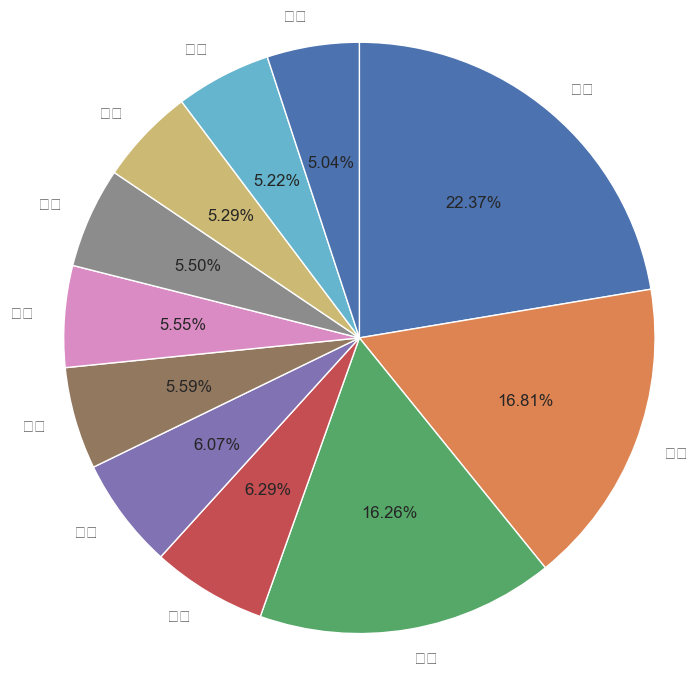

In [77]:
# 绘制各地区samsung销量占比图
plt.pie(data=local_brand,
        x=local_brand['销量'],
       labels=local_brand.index,
       autopct='%.2f%%',
       textprops={'fontsize':12},
       counterclock=False, # 是否逆时针 这里设置为顺时针
       startangle=90, # 设置饼图的初始角度
       radius=2)
plt.show()

#### 销售情况分析

##### 各省销量、销售额情况

In [79]:
local_situation = data.groupby('local').agg(销量=('buy_cnt','sum'),销售额=('amount','sum')).sort_values('销售额')

In [80]:
local_situation['销售额'] = local_situation['销售额'].astype('int')

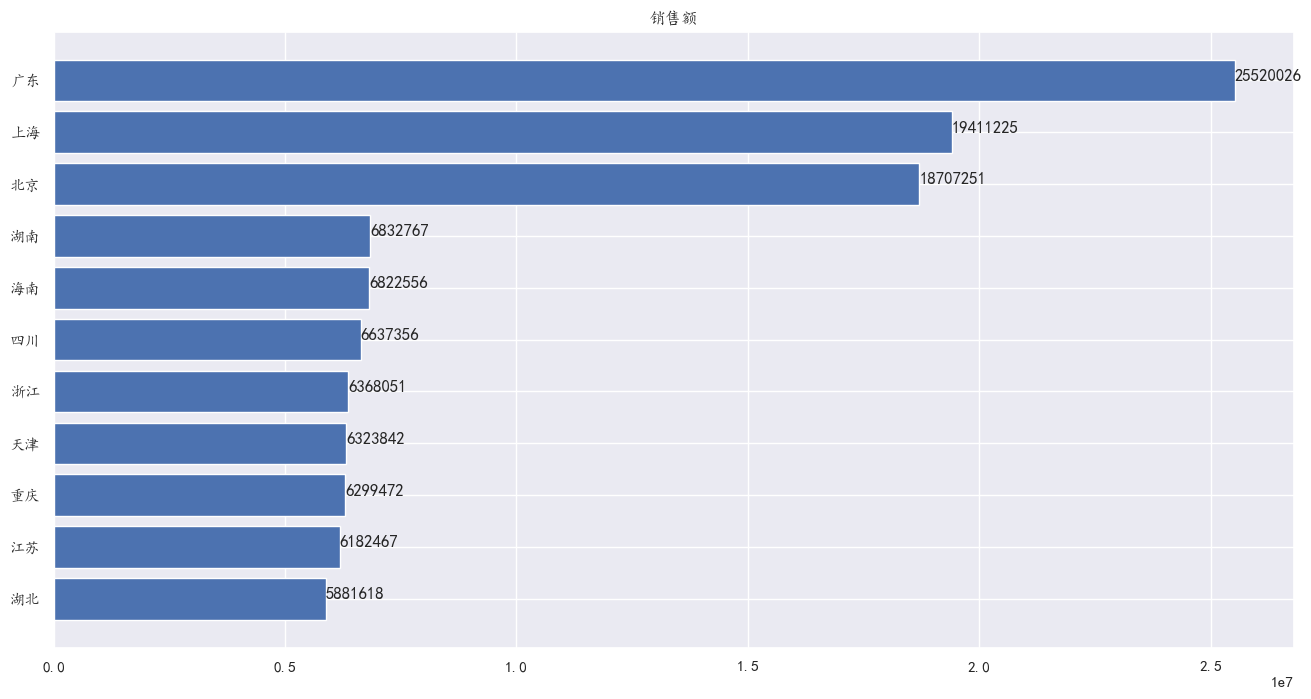

In [85]:
plt.figure(figsize=(16,8))
plt.barh(local_situation.index,local_situation['销售额'])
for i,j in enumerate(local_situation['销售额']):
    plt.text(j+200,local_situation['销售额'].index[i],j)
plt.title('销售额')
plt.show()

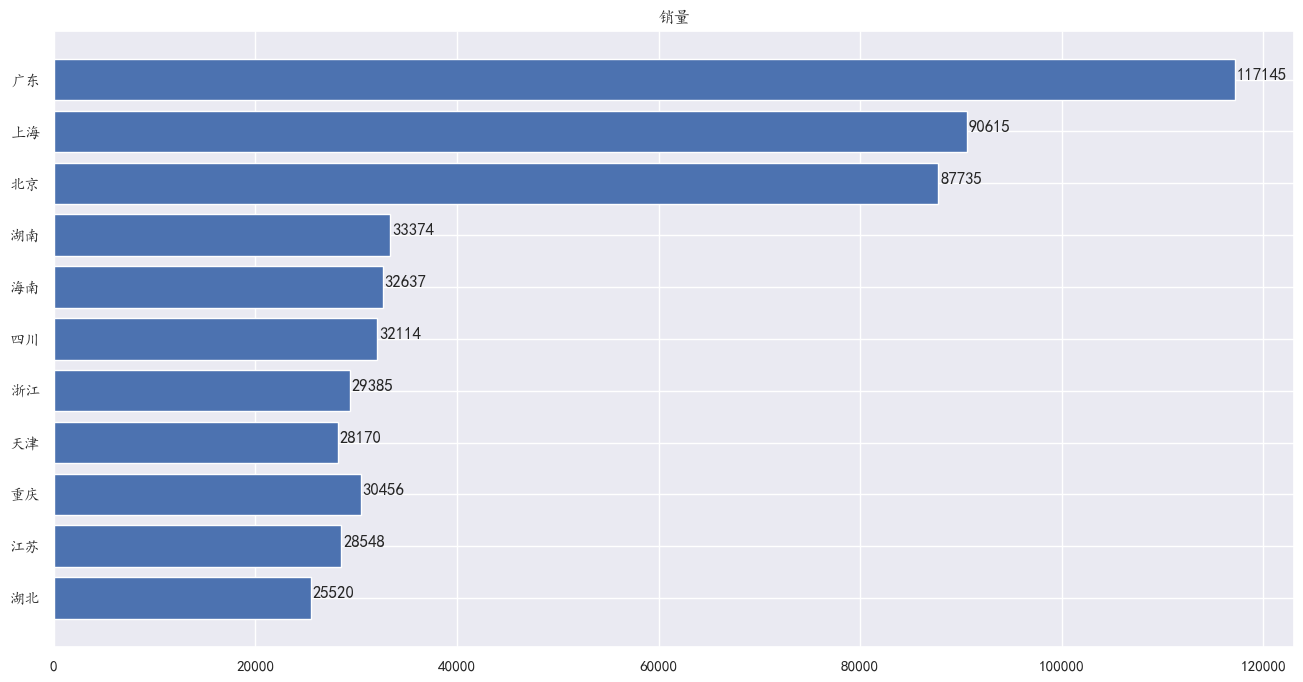

In [87]:
plt.figure(figsize=(16,8))
plt.barh(local_situation.index,local_situation['销量'])
for i,j in enumerate(local_situation['销量']):
    plt.text(j+200,local_situation['销量'].index[i],j)
plt.title('销量')
plt.show()

* 广东、上海、北京的销售额、销量以及客户数量都是最高的
* 销售额与销量1-8月呈现上涨趋势，但是8月份之后就开始下降
* 618和双十一活动兄啊过基本没有得到有效的回报，复盘一下618与双十一活动的内容
* 销售额与销量在5月、7月、8月有均有上升，这三个月的新客户都有增长，幅度也不少，证明拉新活动效果不错；9月份下降，加上9月份的新客户下跌，还有9月份下订单的客户也减少了(其中新客下单的数量减少了四分之三,老客只是稍微下降一点点),是否因为9月份的拉新活动投入减少了呢?也可拆解是哪一渠道的新客减少了。

##### 按日期分析销售额与销量的总体走势

In [88]:
data_date = data.groupby('date').agg(销售额=('amount','sum'),销量=('buy_cnt','sum'))

In [89]:
data_date

,销售额,销量
date,,
2020-01-05,77216.52,580
2020-01-06,61146.03,565
2020-01-07,82381.21,706
2020-01-08,56344.74,446
2020-01-09,58278.71,449
...,...,...
2020-11-17,274274.37,880
2020-11-18,1148309.01,7809
2020-11-19,1124239.09,7628


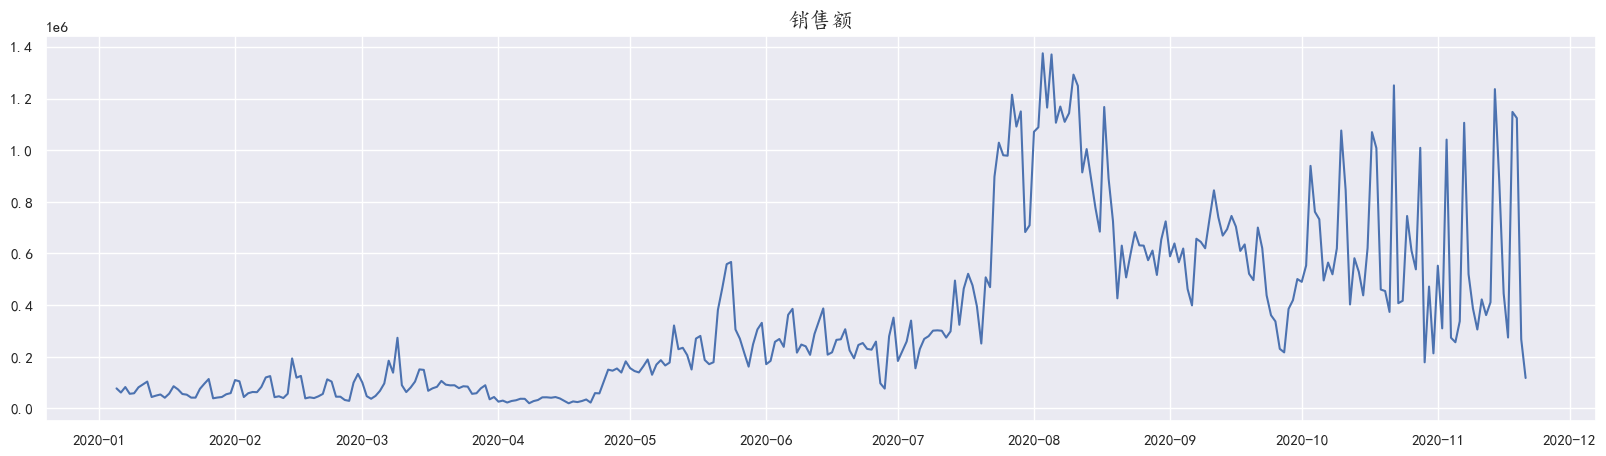

In [91]:
# 按照日期绘制销售额走势图
plt.figure(figsize=(20,5))
plt.plot(data_date.index,data_date['销售额'])
plt.title('销售额',fontsize=16)
plt.show()

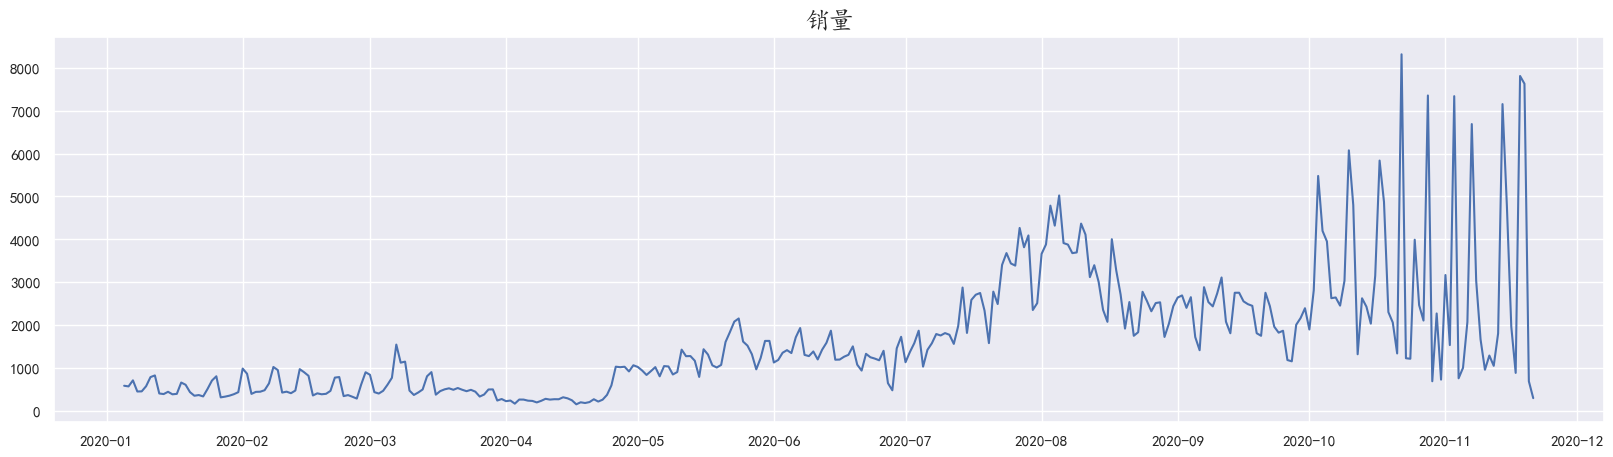

In [93]:
# 按照日期绘制销量走势图
plt.figure(figsize=(20,5))
plt.plot(data_date.index,data_date['销量'])
plt.title('销量',fontsize=18)
plt.show()

* 数据显示,618和双十一当天的销量和销售额并没有很高,反而处于低位(理论上不可能存在这种情况的-数据是否不够真实!!!)
* 假设数据真实，那么可以证实618和双十一的活动效果是非常差的，进行复盘
* 结合后面的分析可以知道，由于公司处于初始起步阶段，618和双十一活动很难和其他比较成熟的公司对比

##### 按月份对销售额和销量进行分析

In [94]:
data_month = data.groupby('month').agg(销售额=('amount','sum'),销量=('buy_cnt','sum'))

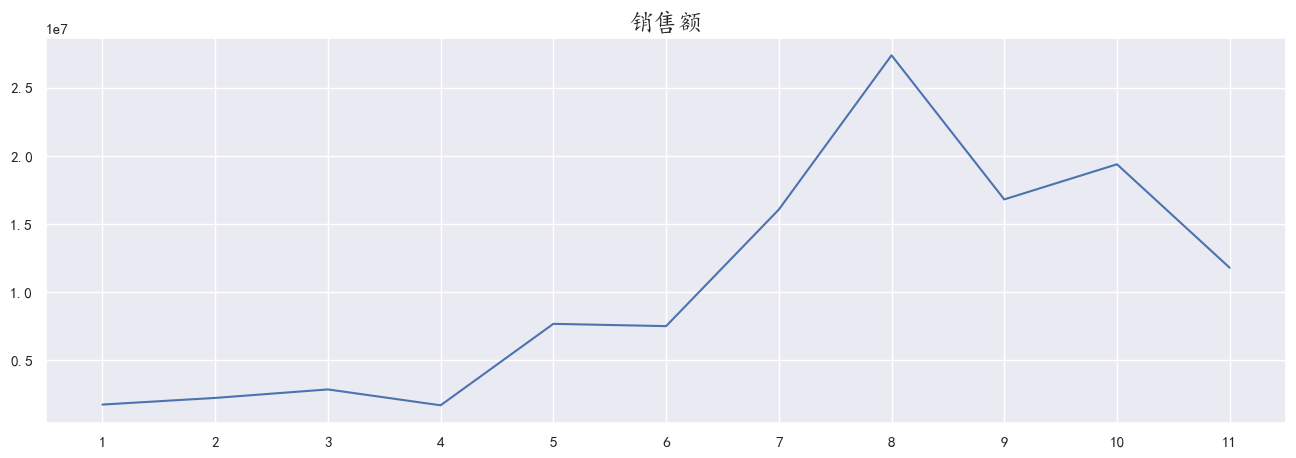

In [95]:
# 按照月份绘制销售额走势图
plt.figure(figsize=(16,5))
plt.plot(data_month.index,data_month['销售额'])
plt.title('销售额', fontsize=18)
plt.xticks(data_month.index)
plt.show()

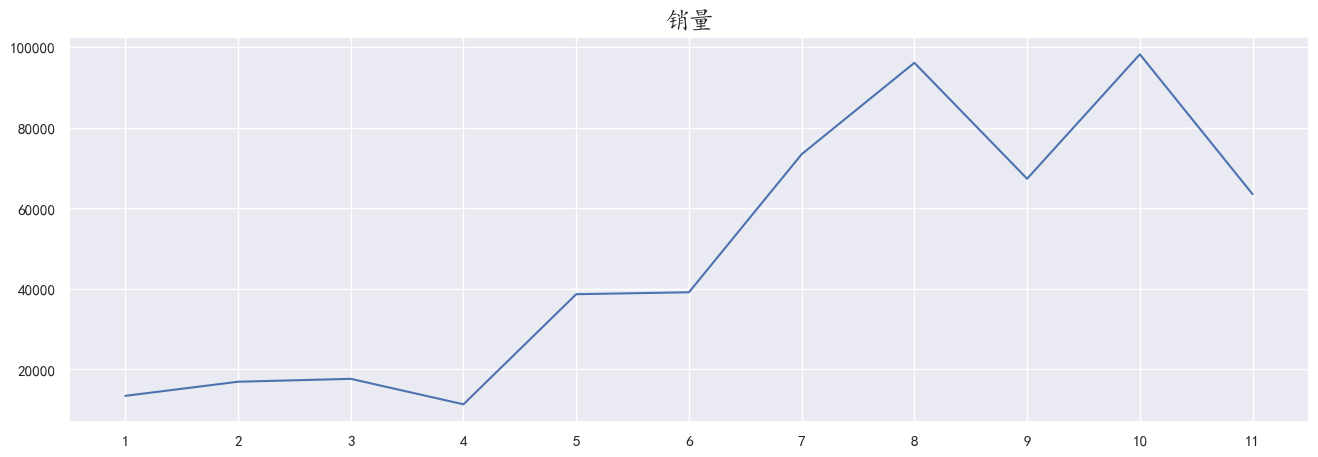

In [96]:
# 按照月份绘制销量走势图
plt.figure(figsize=(16,5))
plt.plot(data_month.index,data_month['销量'])
plt.title('销量',fontsize=18)
plt.xticks(data_month.index)
plt.show()

* 销售额1-8月份呈现上升趋势，在8月份年之后开始下降
* 销量和销售额的走势类似

##### 新老客户销售额和销量对比

In [97]:
# 划分每个用户的首次狗哦买月份（用来确认用户在几月份是属于新客户）
data_user = data.groupby('user_id').agg(首次购买月份=('month','min')).reset_index()

user_all = pd.merge(data,data_user,on='user_id')
user_all['新老客户'] = np.where(user_all['month']==user_all['首次购买月份'],'新客户','老客户')
user_all.head()

,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,date,month,hour,weekday,buy_cnt,amount,首次购买月份,新老客户
0,2318945879811162983,2309018204833317816,2268105479144079872,R,compliment,0.56,1515915625465863936,28.00,女,浙江,2020-05-28,5,9,4,4,2.24,5,新客户
1,2318945879811162983,2309018204833317813,2268105479144079872,R,compliment,0.56,1515915625465863936,28.00,女,浙江,2020-05-28,5,9,4,2,1.12,5,新客户
2,2318945879811162983,2309018204833317817,2268105479144079872,R,compliment,0.56,1515915625465863936,28.00,女,浙江,2020-05-28,5,9,4,1,0.56,5,新客户
3,2318945879811162983,2309018204833317811,2268105479144079872,R,compliment,0.56,1515915625465863936,28.00,女,浙江,2020-05-28,5,9,4,1,0.56,5,新客户
4,2295740594749702229,1515966223509104892,2268105428166508800,electronics.smartphone,apple,1387.01,1515915625448766464,21.00,男,北京,2020-04-26,4,9,0,4,5548.04,3,老客户


In [98]:
# 每个月新客的销售额和销量
user_all_new = user_all[user_all['新老客户']=='新客户'].groupby("month").agg(销售额=('amount','sum'),销量=('buy_cnt','sum'))
user_all_new

,销售额,销量
month,,
1,1729464.93,13449
2,1710658.45,12215
3,1934702.29,11371
4,1214789.79,8221
5,5793011.10,27143
6,4383038.68,18655
7,11668313.82,50192
8,17503323.05,55533
9,8248995.19,26745


In [99]:
# 老客户的销售额和销量
user_all_old = user_all[user_all['新老客户']=='老客户'].groupby('month').agg(销售额=('amount','sum'),销量=('buy_cnt','sum'))
user_all_old

,销售额,销量
month,,
2,506013.86,4733
3,906313.29,6296
4,459660.89,3127
5,1864321.41,11523
6,3106273.64,20492
7,4380494.17,23212
8,9877576.61,40551
9,8548137.42,40564
10,7681078.28,34902


###### 新老客户销售额对比图

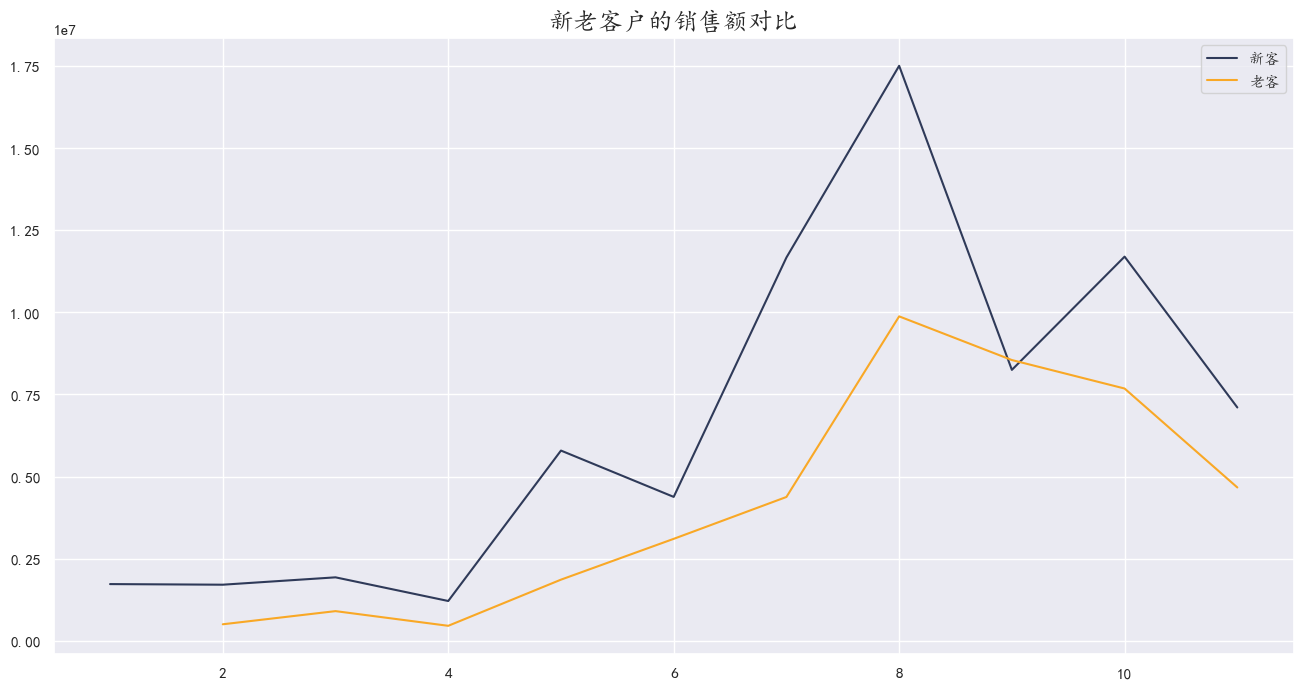

In [103]:
plt.figure(figsize=(16,8))
line1, = plt.plot(user_all_new.index,user_all_new['销售额'],color='#2F3A59')
line2, = plt.plot(user_all_old.index,user_all_old['销售额'],color='#F9A826')
plt.legend([line1,line2],['新客','老客'])
plt.title('新老客户的销售额对比',fontsize=18)
plt.show()

###### 新老客户销量对比图

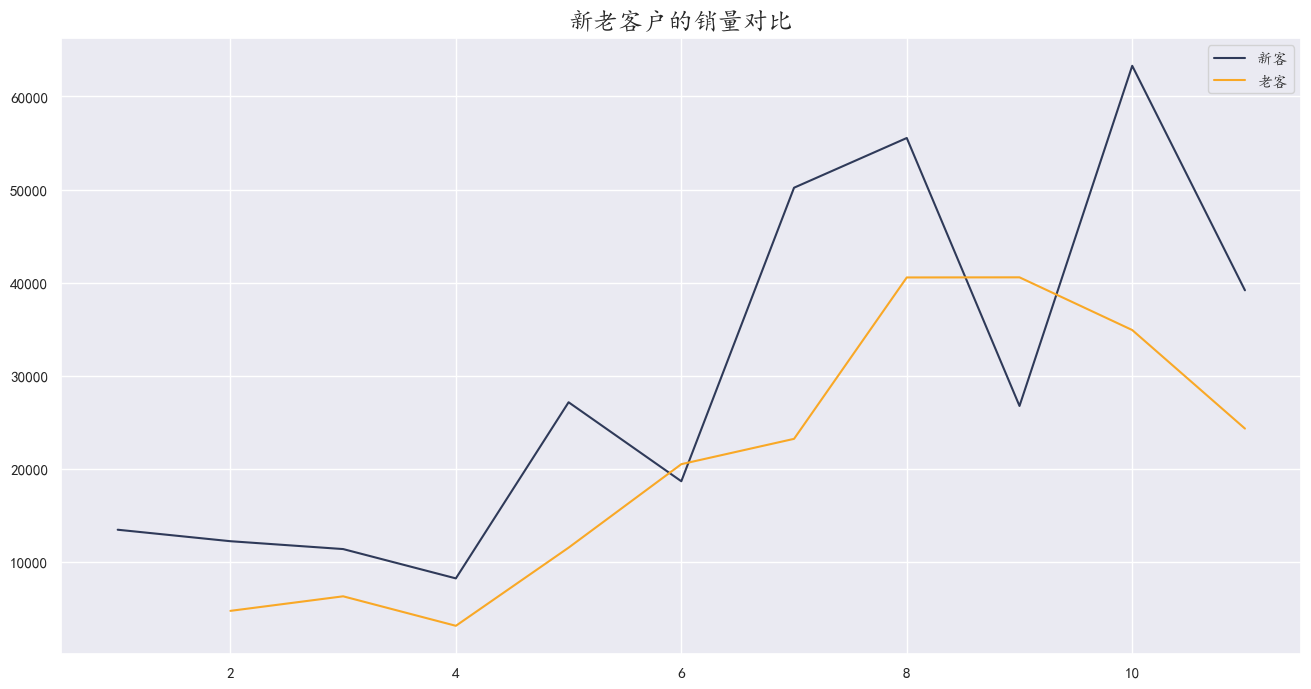

In [104]:
plt.figure(figsize=(16,8))
line1, = plt.plot(user_all_new.index,user_all_new['销量'],color='#2F3A59')
line2, = plt.plot(user_all_old.index,user_all_old['销量'],color='#F9A826')
plt.legend([line1,line2],['新客','老客'])
plt.title('新老客户的销量对比',fontsize=18)
plt.show()

* 从图中可以看出，基本每个月都是新客的贡献大于老客，证明公司处于起步状态，老客户的粘性比较低

##### 按周分析

In [106]:
data_weekday = data.groupby('weekday').agg(销售额=('amount','sum'),销量=('buy_cnt','sum'))

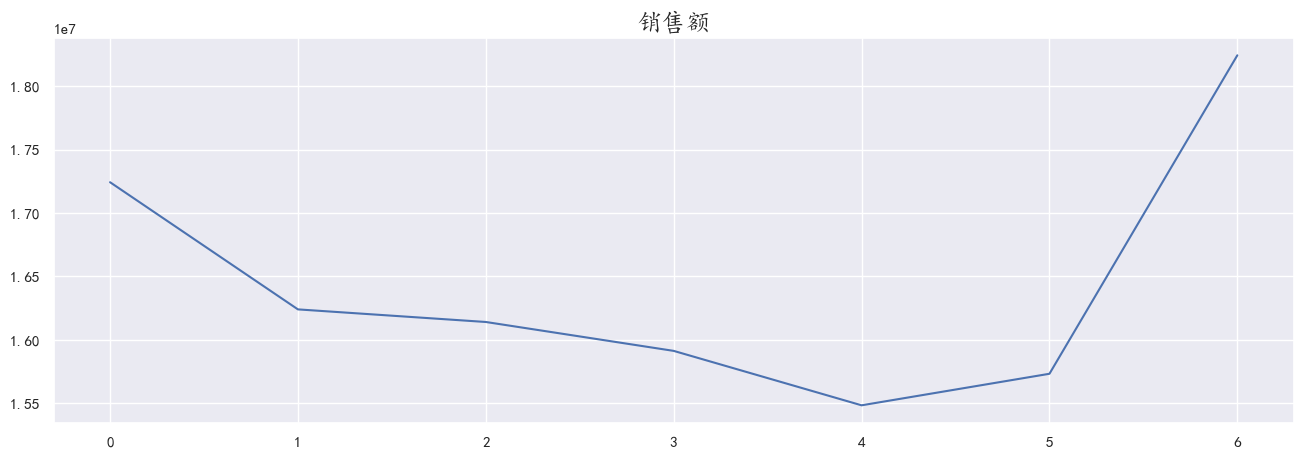

In [107]:
# 按周分析销售额
plt.figure(figsize=(16,5))
plt.plot(data_weekday.index,data_weekday['销售额'])
plt.title('销售额',fontsize=18)
plt.show()

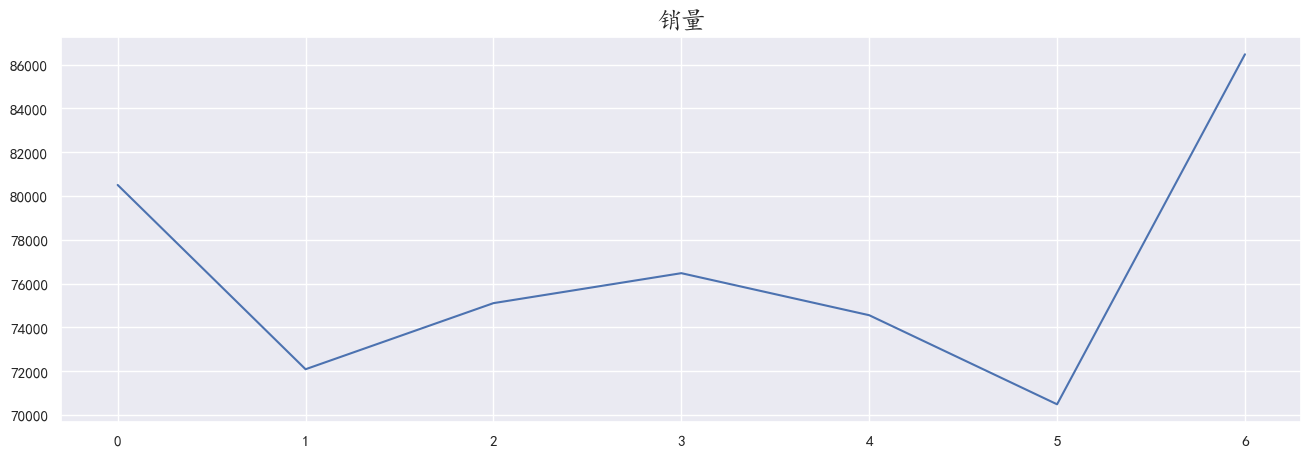

In [108]:
# 按周分析销量
plt.figure(figsize=(16,5))
plt.plot(data_weekday.index,data_weekday['销量'])
plt.title('销量',fontsize=18)
plt.show()

* 从数据中可以看出，销售额和销量在周末回比工作日高，客户比较啊喜欢在周末进行购物，可以在周末多推送商品给用户

###### 按小时分析

In [109]:
data_hour = data.groupby('hour').agg(销售额=('amount','sum'),销量=('buy_cnt','sum'))

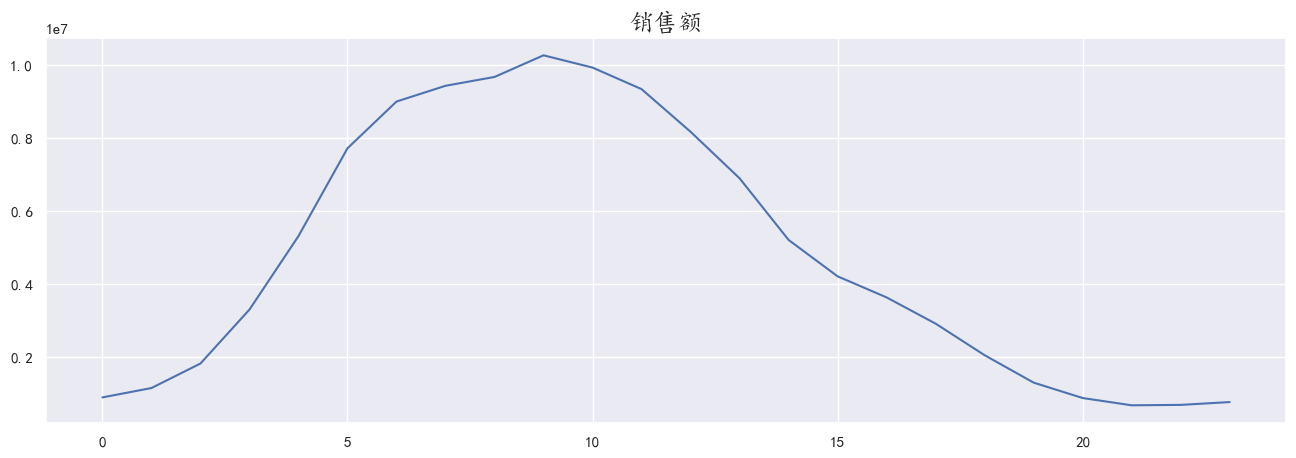

In [111]:
# 绘制按小时销售额走势图
plt.figure(figsize=(16,5))
plt.plot(data_hour.index,data_hour['销售额'])
plt.title('销售额',fontsize=18)
plt.show()


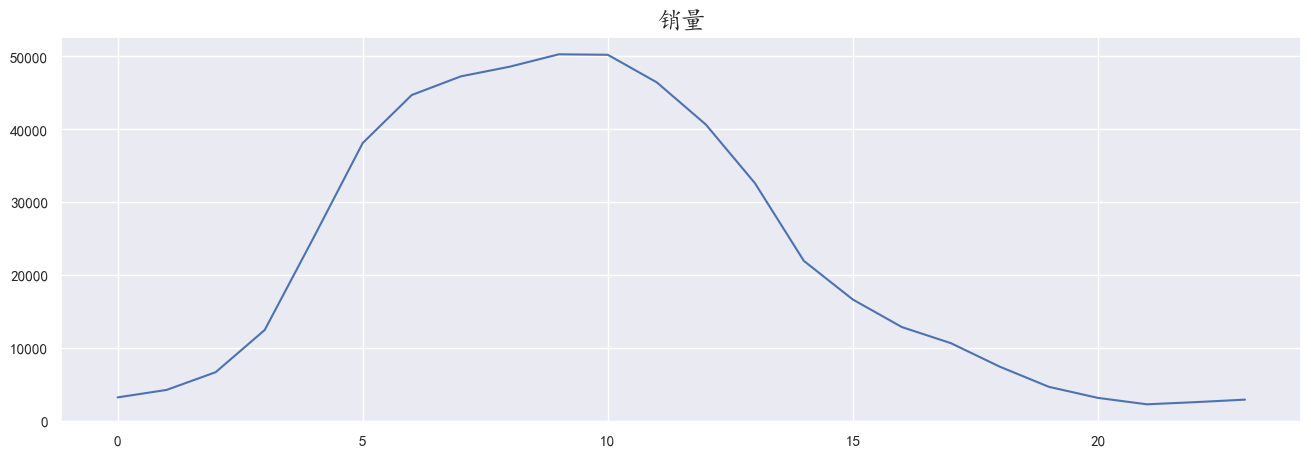

In [112]:
# 绘制按小时销量走势图
plt.figure(figsize=(16,5))
plt.plot(data_hour.index,data_hour['销量'])
plt.title('销量',fontsize=18)
plt.show()

##### 每个月新增用户：首次购买既是新增用户

In [115]:
new_user = data.groupby('user_id').agg({'month':'min'}).reset_index()
new_user.head()

,user_id,month
0,1515915625439951872,7
1,1515915625440038400,9
2,1515915625440051712,10
3,1515915625440099840,5
4,1515915625440121600,5


In [116]:
new_user_month = new_user.groupby('month').agg(新用户数量=('user_id','nunique'))
new_user_month['环比'] = new_user_month.pct_change()

In [117]:
new_user_month

,新用户数量,环比
month,,
1,1813,NaN
2,1613,-0.11
3,1491,-0.08
4,4178,1.80
5,13913,2.33
6,8951,-0.36
7,22036,1.46
8,22052,0.00
9,8163,-0.63


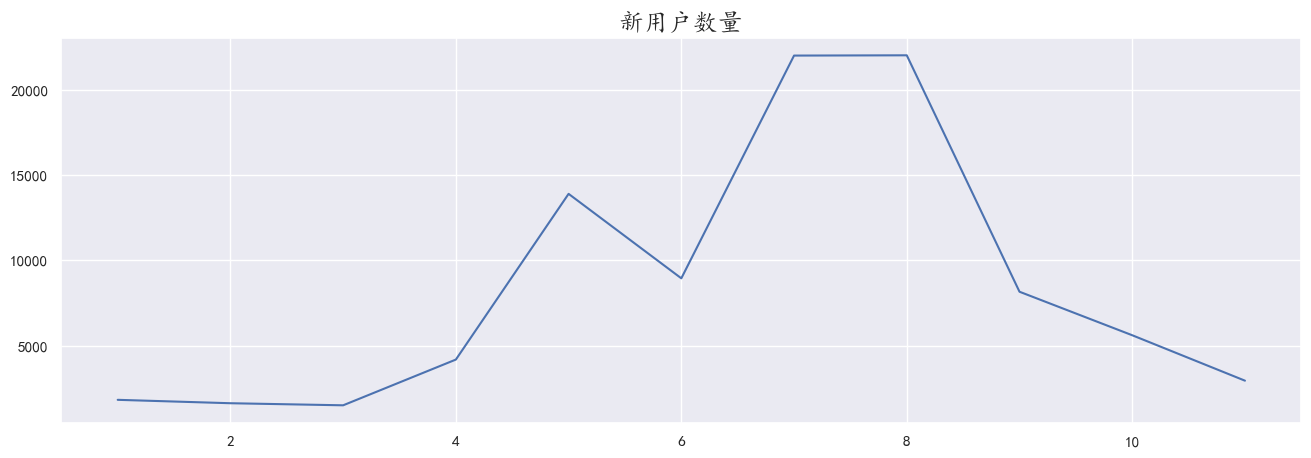

In [118]:
# 绘制月新用户增长图
plt.figure(figsize=(16,5))
plt.plot(new_user_month.index,new_user_month['新用户数量'])
plt.title('新用户数量',fontsize=18)
plt.show()

* 4月比3月新增用户多了差不多2倍,5月又比4月多了2.3倍,证明4月5月的拉新活动有比较好的效果；
* 7月份比6月份增多了1.5倍，8月份与7月份持平，也是证明7月8月的拉新效果不错；
* 9月-11月一致持下降趋势，9月更是比8月下跌了63%；

##### 每月复购率 = 当月都买次数大于2的用户数/总购买人数（同一天多次购买视为一次）

In [120]:
data_buy = data.groupby(['user_id','month','date']).agg(是否购买=('user_id','nunique')).reset_index()
data_buy_month = data_buy.groupby(['user_id','month']).agg(每月购买次数=('是否购买','sum')).reset_index()

In [121]:
data_repurchase = data_buy_month[data_buy_month['每月购买次数']>=2].groupby('month').agg(每月复购人数=('user_id','nunique'))
data_repurchase['每月购买人数'] = data.groupby('month').agg(每月购买人数=('user_id','nunique'))
data_repurchase['复购率'] = data_repurchase['每月复购人数'] / data_repurchase['每月购买人数']

In [122]:
data_repurchase

,每月复购人数,每月购买人数,复购率
month,,,
1,333,1813,0.18
2,511,2237,0.23
3,674,2572,0.26
4,839,5410,0.16
5,3576,17156,0.21
6,2750,13841,0.20
7,8179,29807,0.27
8,10377,35061,0.30
9,6662,19545,0.34


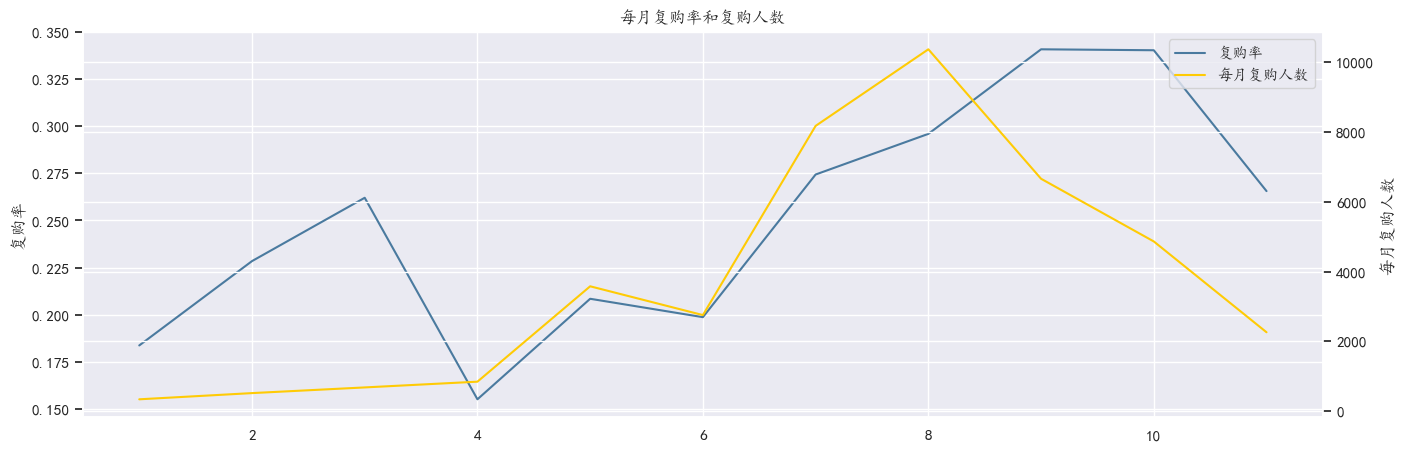

In [124]:
fig,ax1 = plt.subplots(figsize=(16,5))
line1, = ax1.plot(data_repurchase.index,data_repurchase['复购率'],color='#4A7A9F')
ax1.set_ylabel('复购率')

ax2 = ax1.twinx()

line2, = ax2.plot(data_repurchase.index,data_repurchase['每月复购人数'],color='#FFCB05')
ax2.set_ylabel("每月复购人数")
plt.title('每月复购率和复购人数')

plt.legend([line1,line2],['复购率','每月复购人数'])
plt.show()

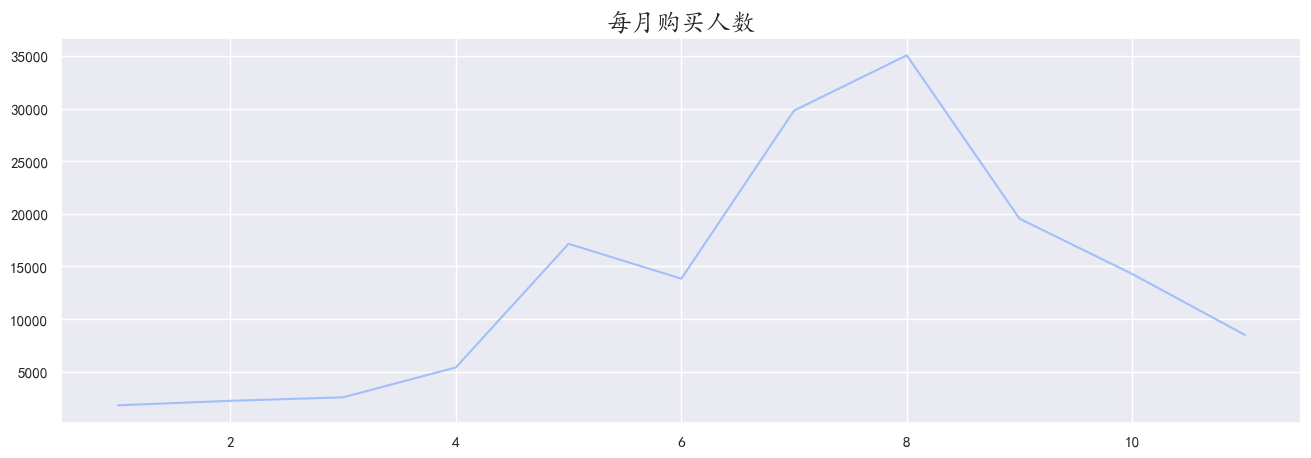

In [125]:
plt.subplots(figsize=(16,5))
plt.plot(data_repurchase.index,data_repurchase['每月购买人数'],c='#A3BFFA')
plt.title('每月购买人数',fontsize=18)
plt.show()

In [128]:
# 划分每个用户的构词购买月份（用来确认用户在几月人是属于新客户）
data_user = data.groupby('user_id').agg(首次购买月份=('month','min')).reset_index()

#data_buy_month 是上面求得的:每个用户每月的购买次数
user = pd.merge(data_buy_month,data_user)
user['新老客户'] = np.where(user['month']==user['首次购买月份'],'新客户','老客户')
#新客户购买人数
user_buy = user[user['新老客户']=='新客户'].groupby('month').agg(新客购买人数=('user_id','nunique'))
#老客户购买人数
user_buy['老客购买人数'] = user[user['新老客户']=='老客户'].groupby('month').agg(老客购买人数=('user_id','nunique'))
user_buy = user_buy.fillna(0)
user_buy

,新客购买人数,老客购买人数
month,,
1,1813,0.00
2,1613,624.00
3,1491,1081.00
4,4178,1232.00
5,13913,3243.00
6,8951,4890.00
7,22036,7771.00
8,22052,13009.00
9,8163,11382.00


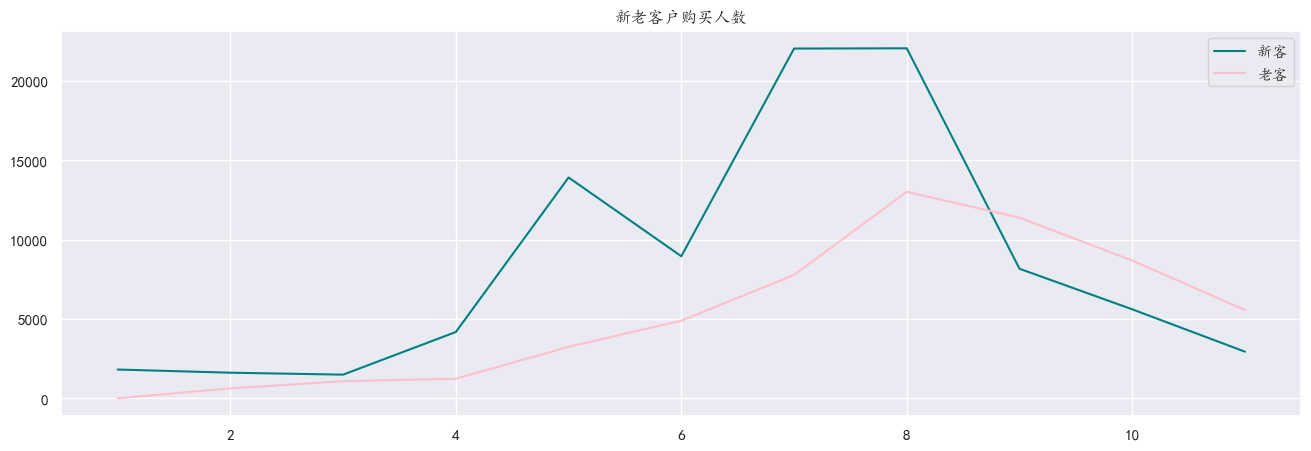

In [130]:
plt.subplots(figsize=(16,5))
line1, = plt.plot(user_buy.index,user_buy['新客购买人数'],c='#008080')
line2, = plt.plot(user_buy.index,user_buy['老客购买人数'],c='#FFC0CB')
plt.title("新老客户购买人数")
plt.legend([line1,line2],['新客','老客'])
plt.show()

* 第一次复购人数增长较多是在5月份，贡献最多的是新客（新客是老客的2倍多）；
* 第二次复购人数增长较多是在7月份，8月份也上涨了，贡献最多的依然是新客；
* 然后9月份开始下降，新客复购人数下降了63%，老客仅下降了13%，贡献率第一次被老客反超新客；
* 复购率1-3月在上升,然后4月份下降到比1月份还低，进一步分析，4月份进行了拉新活动，较多新客当月只购买了一次（有可能是因为拉新活动启动比较晚，新客的复购周期还没到；也有可能这品新客在4月的购买满意度较低，应该着重分析这批客户是否有投诉），所以造成复购率下降；


##### 每月回购率

In [134]:
purchase_cnt = purchase_cnt.T
# purchase_cnt['老客户'] = purchase_cnt.sum(axis=1) - purchase_cnt['新客户']
# purchase_cnt['回购'] = purchase_cnt['回流'] + purchase_cnt['活跃']
# purchase_cnt['回购率'] = purchase_cnt['回购']/purchase_cnt['老客户']
# purchase_cnt
purchase_cnt.sum(axis=1)

新客户    92754.00
回流     21410.00
活跃     36059.00
不活跃   320812.00
dtype: float64

#### RFM模型

In [135]:
user_rfm = data.groupby(['user_id','date']).agg(消费金额=('amount','sum')).reset_index()
user_rfm.head()

,user_id,date,消费金额
0,1515915625439951872,2020-07-09,416.64
1,1515915625440038400,2020-09-22,21.04
2,1515915625440038400,2020-10-28,35.39
3,1515915625440051712,2020-10-23,972.16
4,1515915625440051712,2020-11-16,6517.37


In [136]:
user_rfm = user_rfm.groupby('user_id').agg(最后购买日期=('date','max'),
                                          M=('消费金额','sum'),
                                          F=('date','count')).reset_index()
user_rfm

,user_id,最后购买日期,M,F
0,1515915625439951872,2020-07-09,416.64,1
1,1515915625440038400,2020-10-28,56.43,2
2,1515915625440051712,2020-11-16,7489.53,2
3,1515915625440099840,2020-11-08,4929.86,12
4,1515915625440121600,2020-07-14,182.83,2
...,...,...,...,...
92750,1515915625514887424,2020-11-21,208.31,1
92751,1515915625514887936,2020-11-21,3472.20,1
92752,1515915625514888704,2020-11-21,752.49,1
92753,1515915625514891008,2020-11-21,925.67,1


In [137]:
user_rfm['最后购买日期'] = pd.to_datetime(user_rfm['最后购买日期'])

In [147]:
user_rfm['R'] = user_rfm['最后购买日期'].apply(lambda x:user_rfm['最后购买日期'].max() - x)

In [148]:
user_rfm['最后购买日期'].max()

Timestamp('2020-11-21 00:00:00')

In [149]:
user_rfm['R'].head()

0   135 days
1    24 days
2     5 days
3    13 days
4   130 days
Name: R, dtype: timedelta64[ns]

In [150]:
# 去除 R 后面的 days
user_rfm['R'] = user_rfm['R'].dt.days

In [151]:
user_rfm = user_rfm[['user_id','R','F','M']]

In [153]:
user_rfm

,user_id,R,F,M
0,1515915625439951872,135,1,416.64
1,1515915625440038400,24,2,56.43
2,1515915625440051712,5,2,7489.53
3,1515915625440099840,13,12,4929.86
4,1515915625440121600,130,2,182.83
...,...,...,...,...
92750,1515915625514887424,0,1,208.31
92751,1515915625514887936,0,1,3472.20
92752,1515915625514888704,0,1,752.49
92753,1515915625514891008,0,1,925.67


In [155]:
user_rfm['user_id'] = user_rfm['user_id'].astype('object')

In [156]:
user_rfm.describe(percentiles=(0.01,0.1,0.25,0.75,0.9,0.95,0.99)).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,max
R,92755.00,98.59,54.53,0.00,2.00,24.00,61.00,101.00,127.00,180.00,196.00,211.00,321.00
F,92755.00,2.51,4.56,1.00,1.00,1.00,1.00,1.00,3.00,4.00,6.00,17.00,159.00
M,92755.00,1239.68,4129.72,0.00,6.00,41.64,148.11,456.89,1141.17,2402.53,3823.67,12744.87,160604.07


R的打分:
* (0-30]:5分
* (30-60]:4分
* (60-90]:3分
* (90-120]:2分
* 120以上:1分

F的打分:
* 1次:1分
* 2次:2分
* 3次:3分
* 4次:4分
* 5次及以上:5分

M的打分:
* (0-200]:1分
* (200-500]:2分
* (500-1000]:3分
* (1000-2000]:4分
* 2000以上:5分

In [189]:
# 用户评分
rfm_score = user_rfm.copy()

In [190]:
for i,j in enumerate(rfm_score.R):
    if j <= 30:
        rfm_score['R'][i] = 5
    elif j <= 60:
        rfm_score['R'][i] = 4
    elif j <= 90:
        rfm_score['R'][i] = 3
    elif j <= 120:
        rfm_score['R'][i] = 2
    else:
        rfm_score['R'][i] = 1

In [191]:
for i,j in enumerate(rfm_score.F):
    if j <= 1:
        rfm_score['F'][i] = 1
    elif j <= 2:
        rfm_score['F'][i] = 2
    elif j <= 3:
        rfm_score['F'][i] = 3
    elif j <= 4:
        rfm_score['F'][i] = 4
    else:
        rfm_score['F'][i] = 5

In [192]:
for i,j in enumerate(rfm_score.M):
    if j <= 200:
        rfm_score['M'][i] = 1
    elif j <=500:
        rfm_score['M'][i] = 2
    elif j <= 1000:
        rfm_score['M'][i] = 3
    elif j <= 2000:
        rfm_score['M'][i] = 4
    else :
        rfm_score['M'][i] = 5

In [193]:
rfm_score

,user_id,R,F,M
0,1515915625439951872,1,1,2.00
1,1515915625440038400,5,2,1.00
2,1515915625440051712,5,2,5.00
3,1515915625440099840,5,5,5.00
4,1515915625440121600,1,2,1.00
...,...,...,...,...
92750,1515915625514887424,5,1,2.00
92751,1515915625514887936,5,1,5.00
92752,1515915625514888704,5,1,3.00
92753,1515915625514891008,5,1,3.00


In [194]:
rfm_score['R'].mean()

2.498830251738451

In [195]:
rfm_score['F'].mean()

1.996366772680718

In [196]:
rfm_score['M'].mean()

2.581930893213304

In [197]:
rfm = pd.DataFrame()
rfm['user_id'] = rfm_score['user_id']
rfm['R'] = rfm_score['R'].apply(lambda x:'1' if x >= rfm_score['R'].mean() else '0')
rfm['F'] = rfm_score['F'].apply(lambda x:'1' if x >= rfm_score['F'].mean() else '0')
rfm['M'] = rfm_score['M'].apply(lambda x:'1' if x >= rfm_score['M'].mean() else '0')

In [198]:
rfm

,user_id,R,F,M
0,1515915625439951872,0,0,0
1,1515915625440038400,1,1,0
2,1515915625440051712,1,1,1
3,1515915625440099840,1,1,1
4,1515915625440121600,0,1,0
...,...,...,...,...
92750,1515915625514887424,1,0,0
92751,1515915625514887936,1,0,1
92752,1515915625514888704,1,0,1
92753,1515915625514891008,1,0,1


In [199]:
rfm['result'] = rfm['R'] + rfm['F'] + rfm['M']

In [200]:
rfm

,user_id,R,F,M,result
0,1515915625439951872,0,0,0,000
1,1515915625440038400,1,1,0,110
2,1515915625440051712,1,1,1,111
3,1515915625440099840,1,1,1,111
4,1515915625440121600,0,1,0,010
...,...,...,...,...,...
92750,1515915625514887424,1,0,0,100
92751,1515915625514887936,1,0,1,101
92752,1515915625514888704,1,0,1,101
92753,1515915625514891008,1,0,1,101


In [201]:
for i,j in enumerate(rfm['result']):
    if j == '111':
        rfm['result'][i] = '重要价值客户'
    elif j == '101':
        rfm['result'][i] = '重要发展客户'
    elif j == '011':
        rfm['result'][i] = '重要保持客户'
    elif j == '001':
        rfm['result'][i] = '重要挽留客户'
    elif j == '110':
        rfm['result'][i] = '一般价值客户'
    elif j == '100':
        rfm['result'][i] = '一般发展客户'
    elif j == '010':
        rfm['result'][i] = '一般保持客户'
    elif j == '000':
        rfm['result'][i] = '一般挽留客户'

In [203]:
rfm = rfm[['user_id','result']]

In [204]:
rfm

,user_id,result
0,1515915625439951872,一般挽留客户
1,1515915625440038400,一般价值客户
2,1515915625440051712,重要价值客户
3,1515915625440099840,重要价值客户
4,1515915625440121600,一般保持客户
...,...,...
92750,1515915625514887424,一般发展客户
92751,1515915625514887936,重要发展客户
92752,1515915625514888704,重要发展客户
92753,1515915625514891008,重要发展客户


In [205]:
rfm.result.value_counts()

一般挽留客户    26843
重要价值客户    20012
重要保持客户    11368
一般发展客户     8512
重要挽留客户     8334
一般保持客户     7416
一般价值客户     5855
重要发展客户     4415
Name: result, dtype: int64

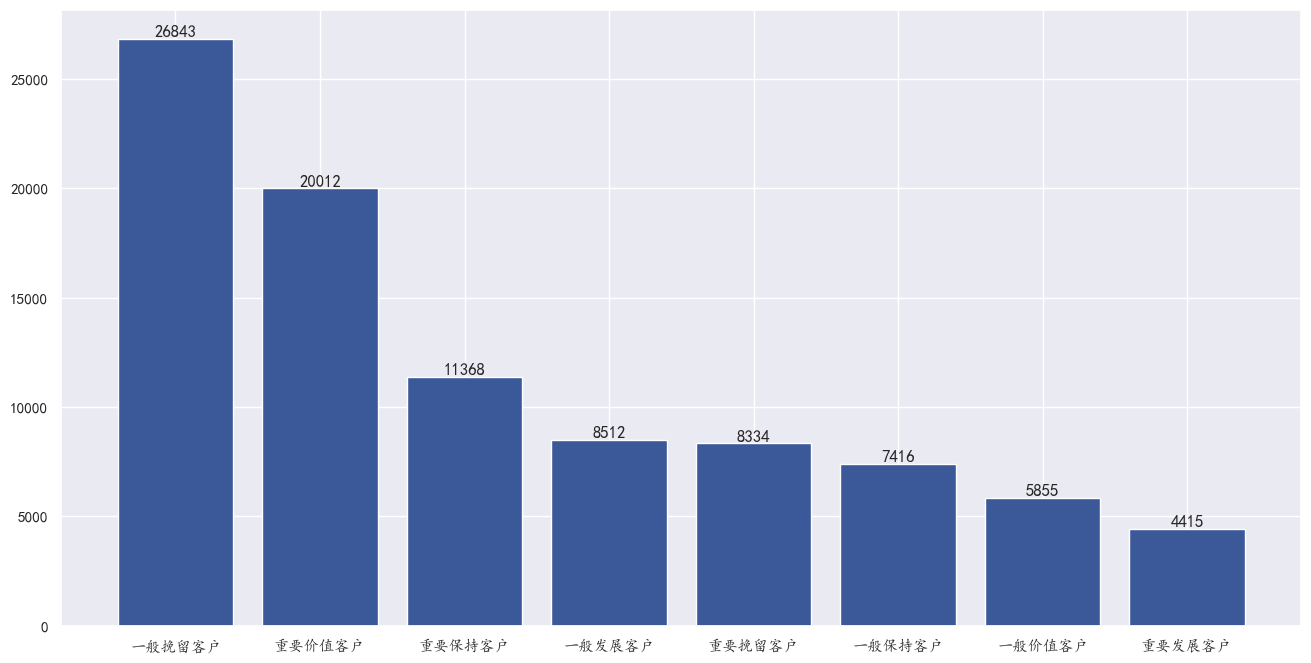

In [210]:
# 绘制客户价值条形图
plt.figure(figsize=(16,8))
plt.bar(rfm.result.value_counts().index,rfm.result.value_counts(),color='#3B5998')
for i,j in enumerate(rfm.result.value_counts()):
    plt.text(i,j + 100,j,ha='center')

* 最重要的客户共有44129人
* 其中重要价值客户又20012人，约占重要客户的50%，对于重要价值客户，要给他们VIP的服务，时刻留意他们的购买反馈
* 重要发展客户有4415人，这类客户消费频率不够高，要想van发提高他们的消费频率，例如发放满减卷等
* 重要保持客户又11368人，这类客户最后一次购买时间距离想在已经很远了，应该发送信息或者电话联系他们也可以发放满减卷给他们，提高他们的复购率
* 重要挽留客户又8334，要想办法挽回这批用户，也可以通过短信的方式

----------
* 一般的客户共有18626人
* 对于一般价值、一般发展、一般保持的客户，在处理好重要客户的情况下，可以酌情去发展维系这批客户
* 期刊中一般挽留用户有26843人，这类客户是要流失的，所以在没有多余的资源的情况下，可以选择放弃这批客户